In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import torch, torch.nn as nn, torch.optim as optim
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_excel("/content/Mainline VDS 315006 - 5SB at W El Camino.xlsx")

In [ ]:
# Parse the Hour column as datetime
df['Hour'] = pd.to_datetime(df['Hour'])

# Define your desired date range
start_date = '2023-01-01'
end_date   = '2024-11-26'

# Filter the dataframe
mask = (df['Hour'] >= pd.to_datetime(start_date)) & \
       (df['Hour'] <= pd.to_datetime(end_date))
df_filtered = df.loc[mask].reset_index(drop=True)

df_filtered.isnull().sum()

df_filtered = df_filtered.sort_values('Hour').reset_index(drop=True)

In [ ]:
df_filtered

Hour  Lane 1 Flow (Veh/Hour)  Lane 1 Occ (%)  \
0     2023-01-01 00:00:00                     147             0.7   
1     2023-01-01 01:00:00                      74             0.4   
2     2023-01-01 02:00:00                      81             0.4   
3     2023-01-01 03:00:00                      45             0.2   
4     2023-01-01 04:00:00                     123             0.6   
...                   ...                     ...             ...   
16513 2024-11-25 20:00:00                     532             2.4   
16514 2024-11-25 21:00:00                     375             1.6   
16515 2024-11-25 22:00:00                     335             1.4   
16516 2024-11-25 23:00:00                     295             1.3   
16517 2024-11-26 00:00:00                     231             1.0   

       Lane 2 Flow (Veh/Hour)  Lane 2 Occ (%)  Lane 3 Flow (Veh/Hour)  \
0                         260             1.6                     239   
1                         189             1.2                     191   
2                         175             1.3                     135   
3                         153             0.9                     139   
4                         244             1.7                     217   
...                       ...             ...                     ...   
16513                     641             4.3                     648   
16514                     556             3.5                     494   
16515                     493             3.3                     411   
16516                     444             2.8                     381   
16517                     364             2.6                     280   

       Lane 3 Occ (%)  Lane 4 Flow (Veh/Hour)  Lane 4 Occ (%)  \
0                 1.5                     199             1.1   
1                 1.2                     122             0.7   
2                 1.0                      79             0.5   
3                 1.1                     100             0.8   
4                 1.4                     125             0.8   
...               ...                     ...             ...   
16513             4.2                     565             3.3   
16514             3.4                     479             2.7   
16515             3.0                     439             2.5   
16516             2.7                     285             1.9   
16517             2.3                     165             1.1   

       Lane 5 Flow (Veh/Hour)  ...  Flow (Veh/Hour)  Occupancy (%)  \
0                          48  ...              893            1.0   
1                          35  ...              611            0.7   
2                          23  ...              493            0.7   
3                          24  ...              461            0.6   
4                          37  ...              746            0.9   
...                       ...  ...              ...            ...   
16513                     170  ...             2556            3.0   
16514                     136  ...             2040            2.4   
16515                      86  ...             1764            2.1   
16516                      76  ...             1481            1.8   
16517                      46  ...             1086            1.4   

       Lane 1 Speed (mph)  Lane 2 Speed (mph)  Lane 3 Speed (mph)  \
0                    76.4                70.9                71.5   
1                    76.4                72.6                71.3   
2                    76.4                72.9                70.9   
3                    76.4                74.0                70.0   
4                    76.3                70.9                69.4   
...                   ...                 ...                 ...   
16513                74.3                64.6                66.5   
16514                75.8                68.6                69.9   
16515                75.8                66.0                68.8   
165

In [ ]:
df_filtered_copy=df_filtered.copy()

In [ ]:
df_filtered_copy['Density (Veh/mi)'] = df_filtered_copy['Flow (Veh/Hour)'] / df_filtered_copy['Speed (mph)']

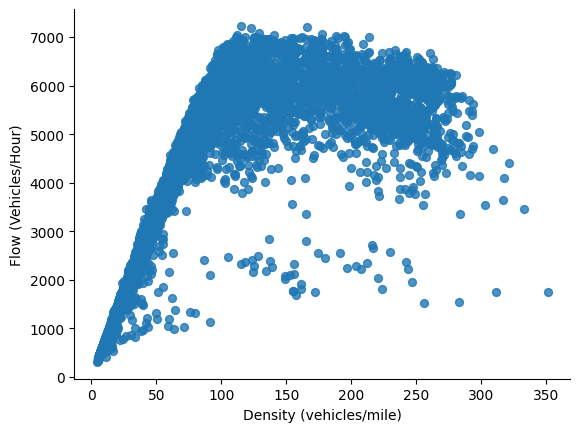

In [ ]:
from matplotlib import pyplot as plt
df_filtered_copy.plot(kind='scatter', x='Density (Veh/mi)', y='Flow (Veh/Hour)', s=32, alpha=.8)
plt.xlabel('Density (vehicles/mile)')         # Custom X-axis label
plt.ylabel('Flow (Vehicles/Hour)')  # Custom Y-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

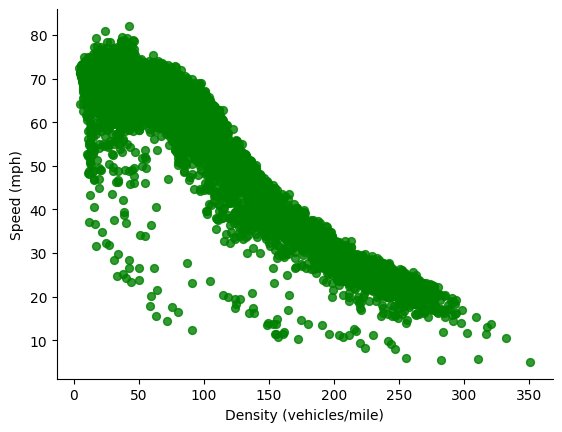

In [ ]:
from matplotlib import pyplot as plt
df_filtered_copy.plot(kind='scatter', x='Density (Veh/mi)', y='Speed (mph)', s=32, alpha=.8, color="green")
plt.xlabel('Density (vehicles/mile)')         # Custom X-axis label
plt.ylabel('Speed (mph)')  # Custom Y-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

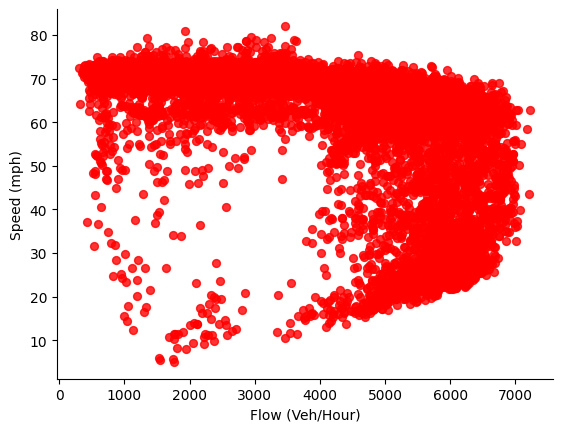

In [ ]:
from matplotlib import pyplot as plt
df_filtered_copy.plot(kind='scatter', x='Flow (Veh/Hour)', y='Speed (mph)', s=32, alpha=.8, color="red")
plt.xlabel('Flow (Veh/Hour)')         # Custom X-axis label
plt.ylabel('Speed (mph)')  # Custom Y-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_filtered_copy.describe()

Hour  Lane 1 Flow (Veh/Hour)  Lane 1 Occ (%)  \
count                          16518            16518.000000    16518.000000   
mean   2023-12-14 08:26:03.094805248              837.172963        5.551629   
min              2023-01-01 00:00:00                0.000000        0.000000   
25%              2023-06-23 01:15:00              358.000000        1.800000   
50%              2023-12-14 00:30:00              928.000000        4.700000   
75%              2024-06-05 00:45:00             1264.000000        6.800000   
max              2024-11-26 00:00:00             1882.000000       48.100000   
std                              NaN              489.655074        5.167695   

       Lane 2 Flow (Veh/Hour)  Lane 2 Occ (%)  Lane 3 Flow (Veh/Hour)  \
count            16518.000000    16518.000000            16518.000000   
mean               805.796646        7.301955              848.915849   
min                  0.000000        0.000000                0.000000   
25%                471.000000        3.100000              416.000000   
50%                912.000000        6.000000              916.000000   
75%               1117.000000        8.900000             1238.000000   
max               1538.000000       49.800000             1678.000000   
std                370.976658        6.060324              439.536877   

       Lane 3 Occ (%)  Lane 4 Flow (Veh/Hour)  Lane 4 Occ (%)  \
count    16518.000000            16518.000000    16518.000000   
mean         7.138824              820.106974        6.646925   
min          0.000000                0.000000        0.000000   
25%          2.900000              344.000000        2.300000   
50%          6.100000              868.000000        5.400000   
75%          8.900000             1225.000000        8.500000   
max         49.800000             1805.000000       49.700000   
std          5.718333              467.535725        5.791363   

       Lane 5 Flow (Veh/Hour)  ...  Occupancy (%)  Lane 1 Speed (mph)  \
count            16518.000000  ...   16518.000000        16518.000000   
mean               352.530331  ...       5.863125           68.153947   
min                  0.000000  ...       0.300000            3.100000   
25%                112.000000  ...       2.200000           68.800000   
50%                339.000000  ...       4.900000           73.500000   
75%                527.000000  ...       7.200000           76.300000   
max               1099.000000  ...      42.500000           86.300000   
std                255.163000  ...       4.986317           14.406133   

       Lane 2 Speed (mph)  Lane 3 Speed (mph)  Lane 4 Speed (mph)  \
count        16518.000000        16518.000000        16518.000000   
mean            62.018755           62.160334           59.983188   
min              3.000000            3.000000            3.000000   
25%             57.200000           60.000000           57.500000   
50%             67.100000           67.200000           65.400000   
75%             71.900000           70.300000           68.200000   
max             84.000000           82.000000           78.500000   
std             14.675607           13.259409           12.916143   

       Lane 5 Speed (mph)   Speed (mph)  # Lane Points    % Observed  \
count        16518.000000  16518.000000        16518.0  16518.000000   
mean            60.016104     62.904262           60.0     85.316806   
min              8.000000      5.000000           60.0      0.000000   
25%             61.300000     61.300000           60.0    100.000000   
50%             63.900000     68.000000           60.0    100.000000   
75%             64.400000     71.000000           60.0    100.000000   
max             74.500000     82.100000           60.0    100.000000   
std              9.095515     13.024180            0.0     34.551770   

       Density (Veh/mi)  
count      16518.000000  
mean          68.990131  
min            4.289655  
25%           24.347310  
50%     

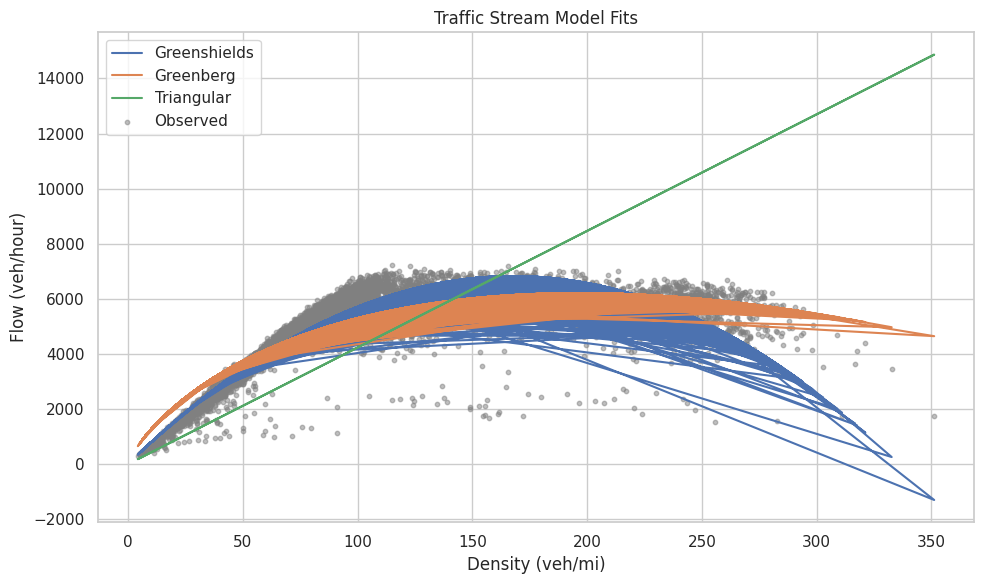

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




# Traffic flow models
def greenshields_model(density, vf, kj):
    return vf * density * (1 - density / kj)

def greenberg_model(density, c, kj):
    return c * density * np.log(kj / density)

def triangular_model(density, vf, w, kj):
    return np.where(density <= kj / 2, vf * density, w * (kj - density))

# Fit models
def fit_and_evaluate(df, model_func, model_name):
    x = df['Density (Veh/mi)']
    y = df['Flow (Veh/Hour)']
    try:
        popt, _ = curve_fit(model_func, x, y, maxfev=10000)
        y_pred = model_func(x, *popt)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        return model_name, popt, rmse, r2, y, y_pred
    except RuntimeError:
        return model_name, None, float('inf'), -np.inf, y, np.zeros_like(y)



results = []
for func, name in [(greenshields_model, 'Greenshields'),
                   (greenberg_model, 'Greenberg'),
                   (triangular_model, 'Triangular')]:
    results.append(fit_and_evaluate(df_filtered_copy, func, name))

# Visualize and tabulate results
result_table = pd.DataFrame({
    'Model': [r[0] for r in results],
    'RMSE': [r[2] for r in results],
    'R^2': [r[3] for r in results]
})

#tools.display_dataframe_to_user(name="Traffic Stream Model Fit Results", dataframe=result_table)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for model_name, popt, _, _, _, y_pred in results:
    if popt is not None:
        plt.plot(df_filtered_copy['Density (Veh/mi)'], y_pred, label=f"{model_name}")
plt.scatter(df_filtered_copy['Density (Veh/mi)'], df_filtered_copy['Flow (Veh/Hour)'], s=10, color='gray', alpha=0.5, label='Observed')
plt.xlabel("Density (veh/mi)")
plt.ylabel("Flow (veh/hour)")
plt.title("Traffic Stream Model Fits")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
result_table

Model         RMSE       R^2
0  Greenshields   465.718467  0.943981
1     Greenberg   607.732268  0.904608
2    Triangular  1720.271186  0.235670

In [ ]:
# Visualize and tabulate results with fitted parameters
param_names = {
    'Greenshields': ['vf', 'kj'],
    'Greenberg': ['c', 'kj'],
    'Triangular': ['vf', 'w', 'kj']
}

rows = []
for model_name, popt, rmse, r2, y, y_pred in results:
    if popt is not None:
        params_str = ', '.join(f"{n}={v:.3f}" for n, v in zip(param_names[model_name], popt))
    else:
        params_str = "Fit Failed"
    rows.append({
        'Model': model_name,
        'RMSE': rmse,
        'R^2': r2,
        'Parameters': params_str
    })

result_table = pd.DataFrame(rows)

# Show result table
print(result_table)


          Model         RMSE       R^2                         Parameters
0  Greenshields   465.718467  0.943981              vf=81.277, kj=335.908
1     Greenberg   607.732268  0.904608               c=31.612, kj=533.683
2    Triangular  1720.271186  0.235670  vf=42.325, w=-26.501, kj=1863.749


In [ ]:
df_filtered[['Flow (Veh/Hour)', 'Speed (mph)', 'Density (Veh/mi)']].describe()

Flow (Veh/Hour)   Speed (mph)  Density (Veh/mi)
count     16518.000000  16518.000000      16518.000000
mean       3664.522763     62.904262         68.990131
std        1967.748455     13.024180         56.975798
min         311.000000      5.000000          4.289655
25%        1690.000000     61.300000         24.347310
50%        4040.000000     68.000000         60.384615
75%        5377.000000     71.000000         88.758065
max        7229.000000     82.100000        351.200000

ADF Statistic: -16.073058958314515
p-value: 5.480336591200052e-29
Critical Values: {'1%': np.float64(-3.430747032677321), '5%': np.float64(-2.8617154724199723), '10%': np.float64(-2.566863399533871)}


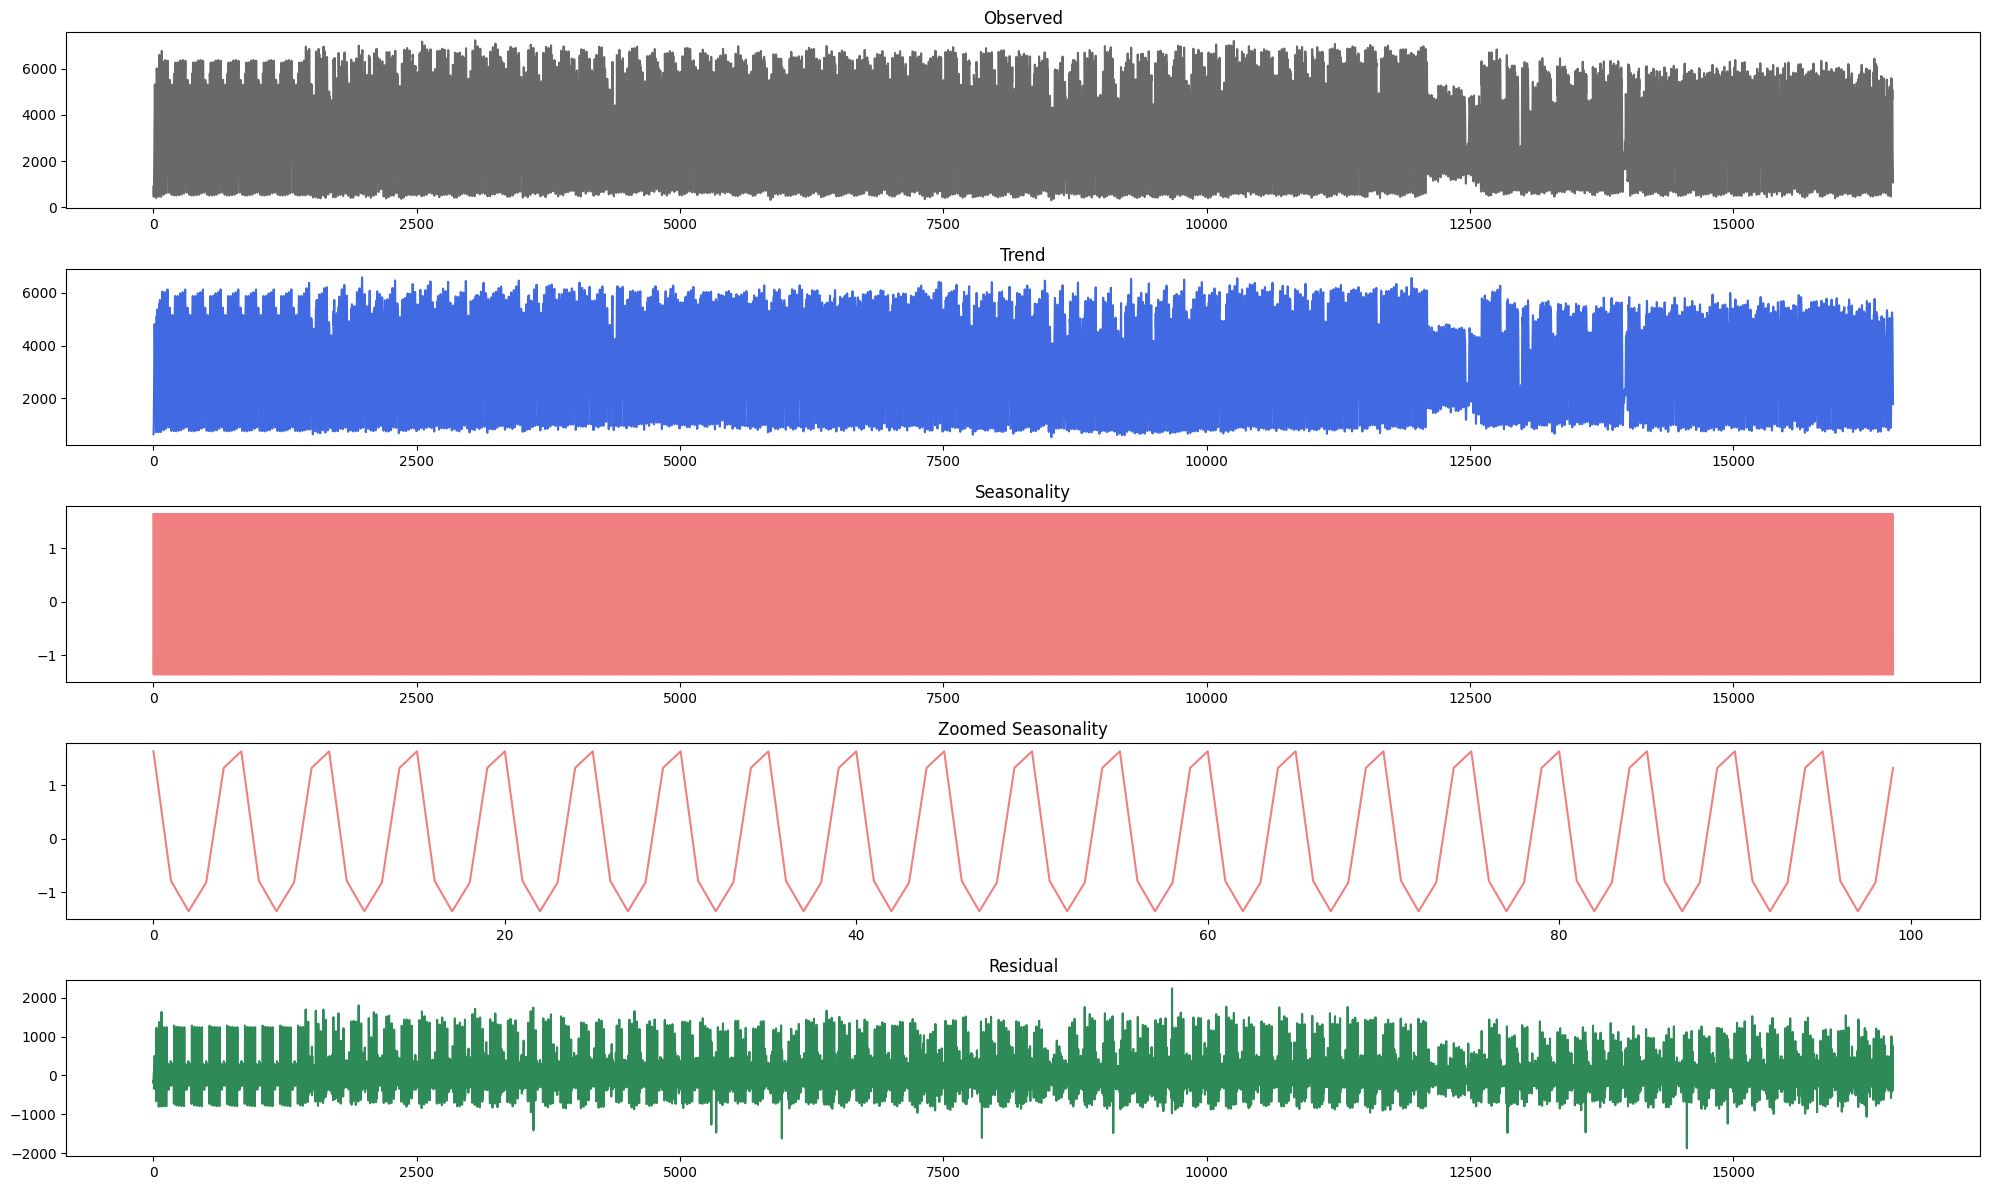

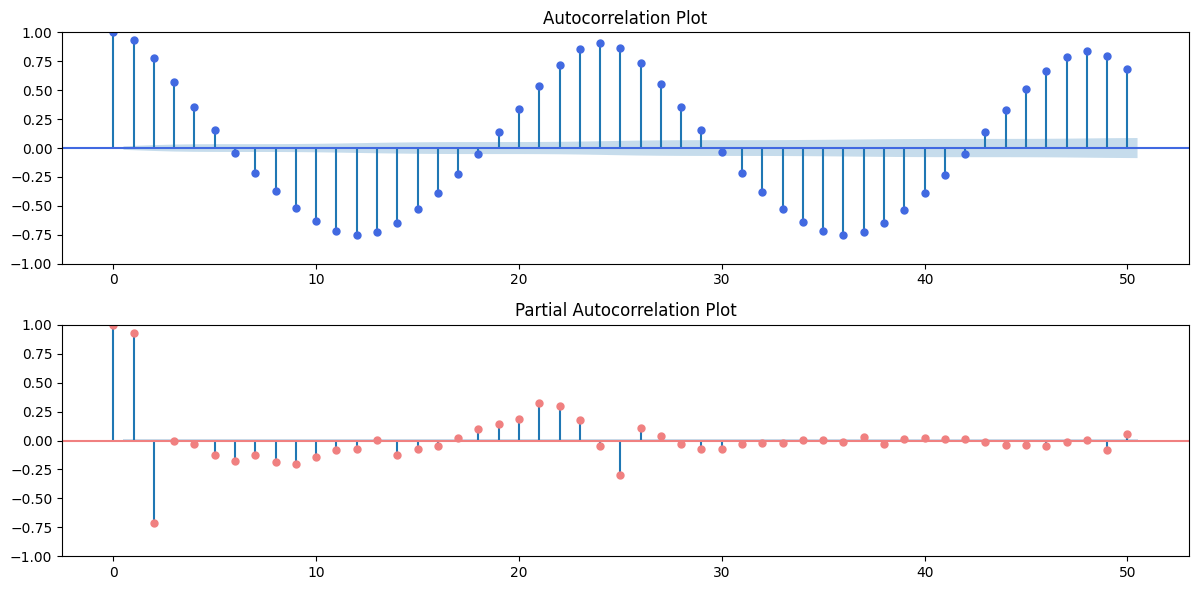

In [ ]:
result = adfuller(df_filtered[['Flow (Veh/Hour)']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_filtered[['Flow (Veh/Hour)']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_filtered['Flow (Veh/Hour)'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_filtered['Flow (Veh/Hour)'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

X_seq shape: (16493, 25, 20) y_seq shape: (16493,)
Train/Val/Test sizes: 11545 2474 2474


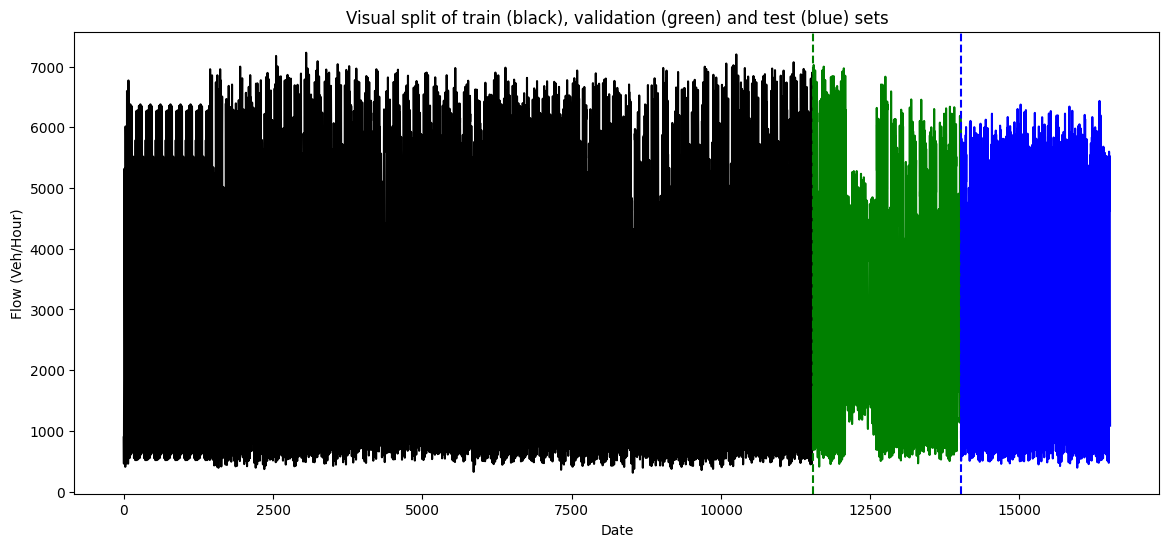

In [ ]:
def make_sequences(df, seq_len=25):
    df_num = df.select_dtypes(include='number')


    # Force 'Occupancy (%)' to be the first column
    cols = df_num.columns.tolist()
    cols.remove('Occupancy (%)')
    cols = ['Occupancy (%)'] + cols
    df_num = df_num[cols]

    scaler = StandardScaler()
    data = scaler.fit_transform(df_num.values)
    flow_idx = df_num.columns.get_loc('Flow (Veh/Hour)')
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, flow_idx])
    return np.array(X), np.array(y), scaler


X_seq, y_seq, scaler = make_sequences(df_filtered, seq_len=25)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)

n = len(X_seq)
i1, i2 = int(0.7*n), int(0.85*n)

X_train, y_train = X_seq[:i1],      y_seq[:i1]
X_val,   y_val   = X_seq[i1:i2],    y_seq[i1:i2]
X_test,  y_test  = X_seq[i2:],      y_seq[i2:]

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_filtered['Flow (Veh/Hour)'].iloc[:i1], color = 'black')
axes.plot(df_filtered['Flow (Veh/Hour)'].iloc[i1 + 1 : i2], color = 'green')
axes.plot(df_filtered['Flow (Veh/Hour)'].iloc[i2 + 1 :], color = 'blue')
axes.axvline(x=df_filtered.index[i1], color='green', linestyle='--')
axes.axvline(x=df_filtered.index[i2], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Flow (Veh/Hour)')
plt.show()

In [ ]:
print("Shape of X_train:", X_train.shape)
print("First 5 values of feature 0 at last timestep:")
print(X_train[:5, -1, 0])  # Should reflect Occupancy (%)

Shape of X_train: (11545, 25, 20)
First 5 values of feature 0 at last timestep:
[-1.41159343 -1.44222817 -1.60969806 -1.56885174 -1.21144649]


In [ ]:
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TrafficDataset(X_train, y_train)
val_ds   = TrafficDataset(X_val,   y_val)
test_ds  = TrafficDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

In [ ]:
input_dim = X_train.shape[2]  # 20 features
seq_len   = X_train.shape[1]  # 25 timesteps

class LSTMModel(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, num_layers=3, dropout=0.7):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim, num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ─── CNNModel ───────────────────────────────────────────────────────────────
class CNNModel(nn.Module):
    def __init__(self, input_dim, seq_len, channels=(64,64), kernel=5, dropout=0.3):
        super().__init__()
        layers = []
        ch_in = input_dim
        for ch_out in channels:
            layers += [
                nn.Conv1d(ch_in, ch_out, kernel, padding=kernel//2),
                nn.ReLU()
            ]
            ch_in = ch_out
        self.conv = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Dropout(dropout),
            nn.Linear(channels[-1] * seq_len, 1)
        )
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x.permute(0,2,1)  # (batch, channels, seq_len)
        x = self.conv(x)
        return self.head(x)

# ─── TCNModel ───────────────────────────────────────────────────────────────
class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, dilation):
        super().__init__()
        pad = (kernel - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel,
                      padding=pad, dilation=dilation),
            nn.ReLU()
        )
    def forward(self, x):
        y = self.net(x)
        # crop to original length
        return y[..., :x.size(-1)]

class TCNModel(nn.Module):
    def __init__(self, input_dim, seq_len,
                 filters=(128,64,32), kernel=3, dilations=(1,2,4,8)):
        super().__init__()
        layers = []
        ch_in = input_dim
        for f,d in zip(filters, dilations):
            layers.append(TCNBlock(ch_in, f, kernel, d))
            ch_in = f
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(filters[-1] * seq_len, 1)
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x.permute(0,2,1)  # (batch, channels, seq_len)
        out = self.tcn(x).flatten(1)
        return self.head(out)

# ─── TransformerModel ──────────────────────────────────────────────────────
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_len,
                 n_heads=8, ff_dim=256, dropout=0.3):
        super().__init__()
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, input_dim))
        self.norm1   = nn.LayerNorm(input_dim)
        self.attn    = nn.MultiheadAttention(input_dim, n_heads,
                                             batch_first=True)
        self.norm2   = nn.LayerNorm(input_dim)
        self.ff      = nn.Sequential(
            nn.Linear(input_dim, ff_dim), nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )
        self.head    = nn.Linear(input_dim * seq_len, 1)
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x + self.pos_emb
        a,_ = self.attn(x, x, x)
        x = self.norm1(x + a)
        y = self.ff(x)
        x = self.norm2(x + y)
        return self.head(x.flatten(1))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def eval_mae(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())
    p = np.vstack(preds).ravel()
    t = np.vstack(trues).ravel()
    return mean_absolute_error(t, p)

Epoch 01 → Train MAE: 0.386, Val MAE: 0.292
Epoch 02 → Train MAE: 0.259, Val MAE: 0.262
Epoch 03 → Train MAE: 0.228, Val MAE: 0.248
Epoch 04 → Train MAE: 0.211, Val MAE: 0.213
Epoch 05 → Train MAE: 0.201, Val MAE: 0.218
Epoch 06 → Train MAE: 0.195, Val MAE: 0.232
Epoch 07 → Train MAE: 0.192, Val MAE: 0.208
Epoch 08 → Train MAE: 0.185, Val MAE: 0.176
Epoch 09 → Train MAE: 0.185, Val MAE: 0.167
Epoch 10 → Train MAE: 0.181, Val MAE: 0.173
Epoch 11 → Train MAE: 0.178, Val MAE: 0.179
Epoch 12 → Train MAE: 0.174, Val MAE: 0.171
Epoch 13 → Train MAE: 0.177, Val MAE: 0.150
Epoch 14 → Train MAE: 0.174, Val MAE: 0.177
Epoch 15 → Train MAE: 0.171, Val MAE: 0.162
Epoch 16 → Train MAE: 0.174, Val MAE: 0.164
Epoch 17 → Train MAE: 0.171, Val MAE: 0.185
Epoch 18 → Train MAE: 0.170, Val MAE: 0.156
Epoch 19 → Train MAE: 0.168, Val MAE: 0.164
Epoch 20 → Train MAE: 0.168, Val MAE: 0.156
Epoch 21 → Train MAE: 0.167, Val MAE: 0.151
Epoch 22 → Train MAE: 0.166, Val MAE: 0.149
Epoch 23 → Train MAE: 0.164, Val

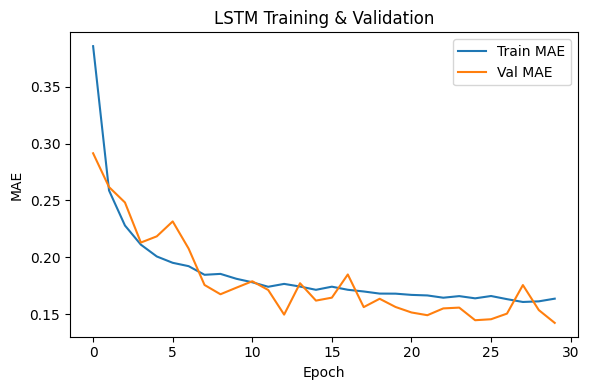

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim).to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.L1Loss()
from collections import defaultdict

n_epochs = 30
history = defaultdict(list)

for epoch in range(1, n_epochs+1):
    # — Train
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # — Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history['train'].append(train_loss)
    history['val'].append(val_loss)
    print(f"Epoch {epoch:02d} → Train MAE: {train_loss:.3f}, Val MAE: {val_loss:.3f}")


from sklearn.metrics import mean_absolute_error

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
        trues.append(yb.numpy())

preds = np.vstack(preds).ravel()
trues = np.vstack(trues).ravel()
# MAE
test_mae = mean_absolute_error(trues, preds)

# MSE
test_mse = mean_squared_error(trues, preds)

# R² Score
test_r2 = r2_score(trues, preds)

# Print results
print(f"MAE  = {test_mae:.3f}")
print(f"MSE = {test_mse:.3f}")
print(f"R²   = {test_r2:.3f}")
print(f"\nLSTM Test MAE: {test_mae:.3f}")

plt.figure(figsize=(6,4))
plt.plot(history['train'], label='Train MAE')
plt.plot(history['val'],   label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('LSTM Training & Validation')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 01 — CNN Train MAE: 0.282, Val MAE: 0.202
Epoch 02 — CNN Train MAE: 0.188, Val MAE: 0.175
Epoch 03 — CNN Train MAE: 0.172, Val MAE: 0.157
Epoch 04 — CNN Train MAE: 0.160, Val MAE: 0.159
Epoch 05 — CNN Train MAE: 0.155, Val MAE: 0.146
Epoch 06 — CNN Train MAE: 0.152, Val MAE: 0.154
Epoch 07 — CNN Train MAE: 0.148, Val MAE: 0.139
Epoch 08 — CNN Train MAE: 0.146, Val MAE: 0.138
Epoch 09 — CNN Train MAE: 0.143, Val MAE: 0.134
Epoch 10 — CNN Train MAE: 0.142, Val MAE: 0.135
Epoch 11 — CNN Train MAE: 0.140, Val MAE: 0.133
Epoch 12 — CNN Train MAE: 0.139, Val MAE: 0.134
Epoch 13 — CNN Train MAE: 0.137, Val MAE: 0.135
Epoch 14 — CNN Train MAE: 0.135, Val MAE: 0.138
Epoch 15 — CNN Train MAE: 0.136, Val MAE: 0.128
Epoch 16 — CNN Train MAE: 0.136, Val MAE: 0.137
Epoch 17 — CNN Train MAE: 0.134, Val MAE: 0.127
Epoch 18 — CNN Train MAE: 0.134, Val MAE: 0.132
Epoch 19 — CNN Train MAE: 0.132, Val MAE: 0.141
Epoch 20 — CNN Train MAE: 0.132, Val MAE: 0.130
Epoch 21 — CNN Train MAE: 0.130, Val MAE

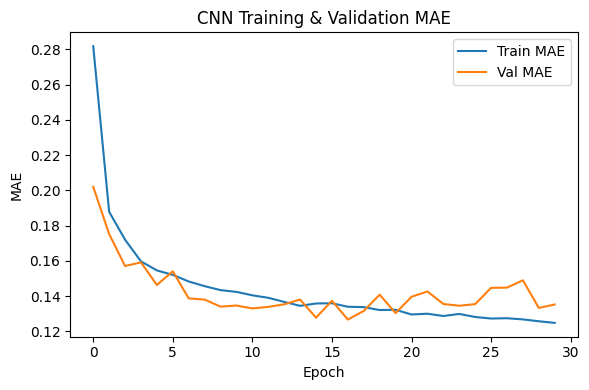

In [ ]:
model = CNNModel(
    input_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    channels=(32,32),
    kernel=5,
    dropout=0.5
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,  weight_decay=1e-5)
criterion = nn.L1Loss()

# Step 7: Train & validate
history_cnn = defaultdict(list)
for epoch in range(1, n_epochs+1):
    # train
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history_cnn['train'].append(train_loss)
    history_cnn['val'].append(val_loss)
    print(f"Epoch {epoch:02d} — CNN Train MAE: {train_loss:.3f}, Val MAE: {val_loss:.3f}")

# Step 8: Test evaluation
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
        trues.append(yb.numpy())
preds = np.vstack(preds).ravel()
trues = np.vstack(trues).ravel()
cnn_test_mae = mean_absolute_error(trues, preds)

# MAE
test_mae = mean_absolute_error(trues, preds)

# MSE
test_mse = mean_squared_error(trues, preds)

# R² Score
test_r2 = r2_score(trues, preds)

# Print results
print(f"MAE  = {test_mae:.3f}")
print(f"MSE = {test_mse:.3f}")
print(f"R²   = {test_r2:.3f}")
print(f"\nCNN Test MAE: {cnn_test_mae:.3f}")

# Step 9: Plot CNN learning curve
plt.figure(figsize=(6,4))
plt.plot(history_cnn['train'], label='Train MAE')
plt.plot(history_cnn['val'],   label='Val MAE')
plt.title('CNN Training & Validation MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend(); plt.tight_layout(); plt.show()

Epoch 01 — TCN Train MAE: 0.270, Val MAE: 0.227
Epoch 02 — TCN Train MAE: 0.182, Val MAE: 0.206
Epoch 03 — TCN Train MAE: 0.160, Val MAE: 0.193
Epoch 04 — TCN Train MAE: 0.139, Val MAE: 0.175
Epoch 05 — TCN Train MAE: 0.119, Val MAE: 0.179
Epoch 06 — TCN Train MAE: 0.107, Val MAE: 0.152
Epoch 07 — TCN Train MAE: 0.103, Val MAE: 0.154
Epoch 08 — TCN Train MAE: 0.098, Val MAE: 0.153
Epoch 09 — TCN Train MAE: 0.096, Val MAE: 0.153
Epoch 10 — TCN Train MAE: 0.093, Val MAE: 0.142
Epoch 11 — TCN Train MAE: 0.090, Val MAE: 0.137
Epoch 12 — TCN Train MAE: 0.090, Val MAE: 0.136
Epoch 13 — TCN Train MAE: 0.087, Val MAE: 0.129
Epoch 14 — TCN Train MAE: 0.084, Val MAE: 0.132
Epoch 15 — TCN Train MAE: 0.086, Val MAE: 0.136
Epoch 16 — TCN Train MAE: 0.082, Val MAE: 0.138
Epoch 17 — TCN Train MAE: 0.084, Val MAE: 0.128
Epoch 18 — TCN Train MAE: 0.084, Val MAE: 0.133
Epoch 19 — TCN Train MAE: 0.079, Val MAE: 0.130
Epoch 20 — TCN Train MAE: 0.079, Val MAE: 0.131
Epoch 21 — TCN Train MAE: 0.081, Val MAE

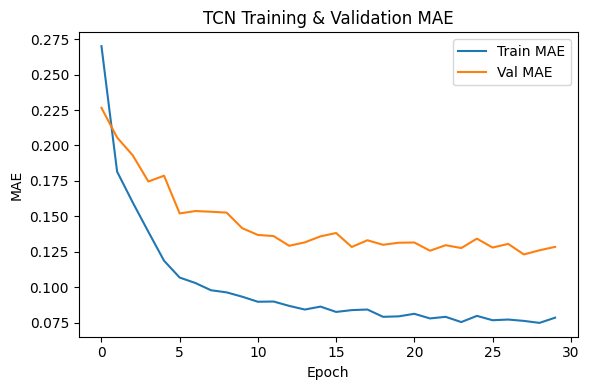

In [ ]:
#
model = TCNModel(
    input_dim = train_ds.X.shape[2],
    seq_len   = train_ds.X.shape[1],
    filters   = (8, 32, 32),
    kernel    = 4,          # <-- corrected here
    dilations = (1, 2, 4)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3,  weight_decay=1e-5)
criterion = nn.L1Loss()

# Step 7: Train & validate
from collections import defaultdict
history_tcn = defaultdict(list)

for epoch in range(1, n_epochs+1):
    # Training
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history_tcn['train'].append(train_loss)
    history_tcn['val'].append(val_loss)
    print(f"Epoch {epoch:02d} — TCN Train MAE: {train_loss:.3f}, Val MAE: {val_loss:.3f}")

# Step 8: Test evaluation
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
        trues.append(yb.numpy())
preds = np.vstack(preds).ravel()
trues = np.vstack(trues).ravel()
tcn_test_mae = mean_absolute_error(trues, preds)

# MAE
test_mae = mean_absolute_error(trues, preds)

# MSE
test_mse = mean_squared_error(trues, preds)

# R² Score
test_r2 = r2_score(trues, preds)

# Print results
print(f"MAE  = {test_mae:.3f}")
print(f"MSE = {test_mse:.3f}")
print(f"R²   = {test_r2:.3f}")
print(f"\nTCN Test MAE: {tcn_test_mae:.3f}")

# Step 9: Plot TCN learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_tcn['train'], label='Train MAE')
plt.plot(history_tcn['val'],   label='Val MAE')
plt.title('TCN Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 01 — Trans Train MAE: 0.260, Val MAE: 0.201
Epoch 02 — Trans Train MAE: 0.153, Val MAE: 0.171
Epoch 03 — Trans Train MAE: 0.128, Val MAE: 0.189
Epoch 04 — Trans Train MAE: 0.117, Val MAE: 0.157
Epoch 05 — Trans Train MAE: 0.110, Val MAE: 0.149
Epoch 06 — Trans Train MAE: 0.112, Val MAE: 0.146
Epoch 07 — Trans Train MAE: 0.105, Val MAE: 0.155
Epoch 08 — Trans Train MAE: 0.102, Val MAE: 0.145
Epoch 09 — Trans Train MAE: 0.099, Val MAE: 0.142
Epoch 10 — Trans Train MAE: 0.095, Val MAE: 0.144
Epoch 11 — Trans Train MAE: 0.095, Val MAE: 0.155
Epoch 12 — Trans Train MAE: 0.097, Val MAE: 0.142
Epoch 13 — Trans Train MAE: 0.095, Val MAE: 0.138
Epoch 14 — Trans Train MAE: 0.096, Val MAE: 0.140
Epoch 15 — Trans Train MAE: 0.093, Val MAE: 0.139
Epoch 16 — Trans Train MAE: 0.092, Val MAE: 0.150
Epoch 17 — Trans Train MAE: 0.089, Val MAE: 0.139
Epoch 18 — Trans Train MAE: 0.090, Val MAE: 0.141
Epoch 19 — Trans Train MAE: 0.094, Val MAE: 0.138
Epoch 20 — Trans Train MAE: 0.088, Val MAE: 0.137


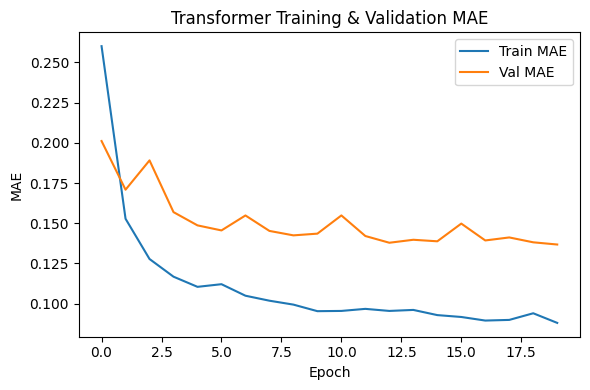

In [ ]:
model = TransformerModel(
    input_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    n_heads=4,
    ff_dim=4,
    dropout=0.5
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,  weight_decay=1e-5)
criterion = nn.L1Loss()

n_epochs = 20

# Step 7: Train & validate
history_trans = defaultdict(list)
for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history_trans['train'].append(train_loss)
    history_trans['val'].append(val_loss)
    print(f"Epoch {epoch:02d} — Trans Train MAE: {train_loss:.3f}, Val MAE: {val_loss:.3f}")

# Step 8: Test evaluation
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
        trues.append(yb.numpy())
preds = np.vstack(preds).ravel()
trues = np.vstack(trues).ravel()
trans_test_mae = mean_absolute_error(trues, preds)


# MAE
test_mae = mean_absolute_error(trues, preds)

# MSE
test_mse = mean_squared_error(trues, preds)

# R² Score
test_r2 = r2_score(trues, preds)

# Print results
print(f"MAE  = {test_mae:.3f}")
print(f"MSE = {test_mse:.3f}")
print(f"R²   = {test_r2:.3f}")
print(f"\nTransformer Test MAE: {trans_test_mae:.3f}")

# Step 9: Plot Transformer learning curve
plt.figure(figsize=(6,4))
plt.plot(history_trans['train'], label='Train MAE')
plt.plot(history_trans['val'],   label='Val MAE')
plt.title('Transformer Training & Validation MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# ─── CNN→LSTM Hybrid ─────────────────────────────────────────────────────────
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, seq_len,
                 conv_ch=(32,32), lstm_dim=64, dropout=0.5):
        super().__init__()
        convs = []
        ch_in = input_dim
        for ch_out in conv_ch:
            convs += [
                nn.Conv1d(ch_in, ch_out, 3, padding=1),
                nn.ReLU()
            ]
            ch_in = ch_out
        self.conv = nn.Sequential(*convs)
        self.lstm = nn.LSTM(conv_ch[-1], lstm_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_dim, 1)
        )
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x.permute(0,2,1)        # (batch, channels, seq_len)
        f, _ = self.conv(x).permute(0,2,1), None  # (batch, seq_len, ch_out)
        out, _ = self.lstm(f)
        return self.head(out[:, -1, :])



class CNNLSTMAttn(nn.Module):
    def __init__(self, in_dim, seq_len,
                 conv_ch=(64,32), lstm_dim=32, attn_dim=64, dropout=0.5):
        super().__init__()
        convs, ch = [], in_dim
        for c in conv_ch:
            convs += [nn.Conv1d(ch, c, 3, padding=1), nn.ReLU()]
            ch = c
        self.conv = nn.Sequential(*convs)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.attn_lin = nn.Linear(lstm_dim, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1, bias=False)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim,1))

    def forward(self, x):
        # x: (B,T,F) → (B,F,T)
        z = self.conv(x.permute(0,2,1)).permute(0,2,1)  # (B,T,ch)
        H, _ = self.lstm(z)                            # (B,T,lstm_dim)
        e = torch.tanh(self.attn_lin(H))               # (B,T,attn_dim)
        scores = self.attn_score(e).squeeze(-1)        # (B,T)
        α = torch.softmax(scores, dim=-1).unsqueeze(-1)# (B,T,1)
        c = (H * α).sum(dim=1)                         # (B,lstm_dim)
        return self.head(c)                            # (B,1)

class TCNLSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 filters=(128,64,32), kernel=3, dilations=(1,2,4,8),
                 lstm_dim=64, dropout=0.5):
        super().__init__()
        layers, ch = [], in_dim
        for f,d in zip(filters, dilations):
            pad = (kernel-1)*d
            layers += [nn.Conv1d(ch,f,kernel,padding=pad,dilation=d),
                       nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim,1))

    def forward(self, x):
        # x: (B,T,F) → (B,F,T)
        z = self.tcn(x.permute(0,2,1))[...,:x.size(1)]
        z = z.permute(0,2,1)  # (B,T,ch)
        H, _ = self.lstm(z)   # (B,T,lstm_dim)
        return self.head(H[:,-1,:])

class TransLSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 n_heads=4, ff_dim=256, lstm_dim=64, dropout=0.5):
        super().__init__()

        # Round up in_dim to make it divisible by n_heads
        self.embed_dim = ((in_dim + n_heads - 1) // n_heads) * n_heads
        self.input_proj = nn.Linear(in_dim, self.embed_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.embed_dim))

        self.attn = nn.MultiheadAttention(self.embed_dim, n_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Linear(self.embed_dim, ff_dim), nn.ReLU(),
            nn.Linear(ff_dim, self.embed_dim)
        )
        self.lstm = nn.LSTM(self.embed_dim, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        x = self.input_proj(x) + self.pos_emb  # (B, T, embed_dim)
        a, _ = self.attn(x, x, x)
        y = self.ff(a + x)
        H, _ = self.lstm(y)
        return self.head(H[:, -1, :])




In [ ]:
def run_single_model(model_name, epochs=20, lr=1e-3, weight_decay=1e-5):
    # ─── Device ───
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ─── Model Selection ───
    hybrids = {
        'TCN→LSTM': TCNLSTM(
            in_dim=input_dim, seq_len=seq_len,
            filters=(32, 16), kernel=4, dilations=(1,2),
            lstm_dim=16, dropout=0.6
        ),
        'Trans→LSTM': TransLSTM(
            in_dim=input_dim, seq_len=seq_len,
            n_heads=4, ff_dim=32,
            lstm_dim=16, dropout=0.7
        ),
        'CNN→LSTM': CNNLSTMModel(
            input_dim=input_dim, seq_len=seq_len,
            conv_ch=(16, 128), lstm_dim=16, dropout=0.7
        )
    }

    model = hybrids[model_name].to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()

    # ─── Training ───
    train_maes, val_maes = [], []

    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            pred = out if isinstance(out, torch.Tensor) else out[0]
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        tr_mae, _, _ = eval_model(model, train_loader)
        va_mae, _, _ = eval_model(model, val_loader)
        train_maes.append(tr_mae)
        val_maes.append(va_mae)
        print(f"{model_name} Epoch {epoch:02d}: Train MAE {tr_mae:.3f}, Val MAE {va_mae:.3f}")

    # ─── Final Evaluation ───
    te_mae, preds, trues = eval_model(model, test_loader)
    te_mse = mean_squared_error(trues, preds)
    te_r2  = r2_score(trues, preds)

    print(f"\n{model_name} Test MAE: {te_mae:.3f}")
    print(f"{model_name} Test MSE: {te_mse:.3f}")
    print(f"{model_name} Test R²:  {te_r2:.3f}")

    # ─── Learning Curve ───
    plt.figure(figsize=(6,4))
    plt.plot(range(1, epochs+1), train_maes, label='Train MAE')
    plt.plot(range(1, epochs+1), val_maes,   label='Val MAE')
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Epoch"); plt.ylabel("MAE")
    plt.legend(); plt.tight_layout(); plt.show()

    # ─── Forecast Plot ───
    start_idx = len(train_ds) + len(val_ds)
    hours = df_filtered['Hour'].iloc[start_idx : start_idx + len(trues)].reset_index(drop=True)

    plt.figure(figsize=(12,5))
    plt.plot(hours[-300:], trues[-300:], label='Actual', linewidth=2)
    plt.plot(hours[-300:], preds[-300:], label='Predicted', linewidth=2, alpha=0.7)
    plt.xlabel('Hour'); plt.ylabel('Flow (Veh/Hour)')
    plt.title(f"{model_name}: Last 300 Actual vs Predicted")
    plt.legend(); plt.tight_layout(); plt.show()

    return {
        'mae': te_mae, 'mse': te_mse, 'r2': te_r2,
        'train_curve': train_maes, 'val_curve': val_maes,
        'preds': preds, 'trues': trues
    }


In [ ]:
 run_single_model('TCN→LSTM')

NameError: name 'eval_model' is not defined

Trans→LSTM Epoch 01: Train MAE 0.237, Val MAE 0.225
Trans→LSTM Epoch 02: Train MAE 0.205, Val MAE 0.194
Trans→LSTM Epoch 03: Train MAE 0.161, Val MAE 0.165
Trans→LSTM Epoch 04: Train MAE 0.191, Val MAE 0.193
Trans→LSTM Epoch 05: Train MAE 0.177, Val MAE 0.180
Trans→LSTM Epoch 06: Train MAE 0.147, Val MAE 0.151
Trans→LSTM Epoch 07: Train MAE 0.179, Val MAE 0.195
Trans→LSTM Epoch 08: Train MAE 0.164, Val MAE 0.186
Trans→LSTM Epoch 09: Train MAE 0.155, Val MAE 0.159
Trans→LSTM Epoch 10: Train MAE 0.156, Val MAE 0.156
Trans→LSTM Epoch 11: Train MAE 0.157, Val MAE 0.158
Trans→LSTM Epoch 12: Train MAE 0.147, Val MAE 0.156
Trans→LSTM Epoch 13: Train MAE 0.162, Val MAE 0.156
Trans→LSTM Epoch 14: Train MAE 0.137, Val MAE 0.155
Trans→LSTM Epoch 15: Train MAE 0.147, Val MAE 0.164
Trans→LSTM Epoch 16: Train MAE 0.126, Val MAE 0.150
Trans→LSTM Epoch 17: Train MAE 0.144, Val MAE 0.155
Trans→LSTM Epoch 18: Train MAE 0.178, Val MAE 0.174
Trans→LSTM Epoch 19: Train MAE 0.157, Val MAE 0.163
Trans→LSTM E

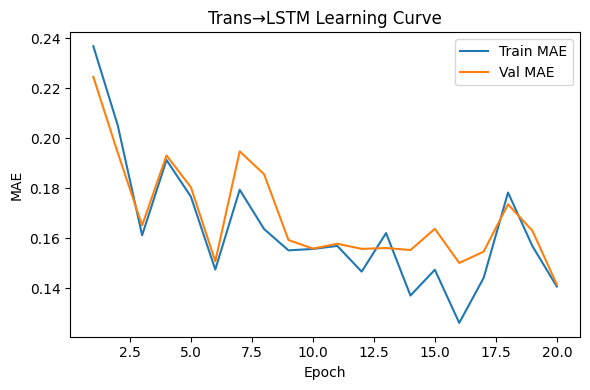

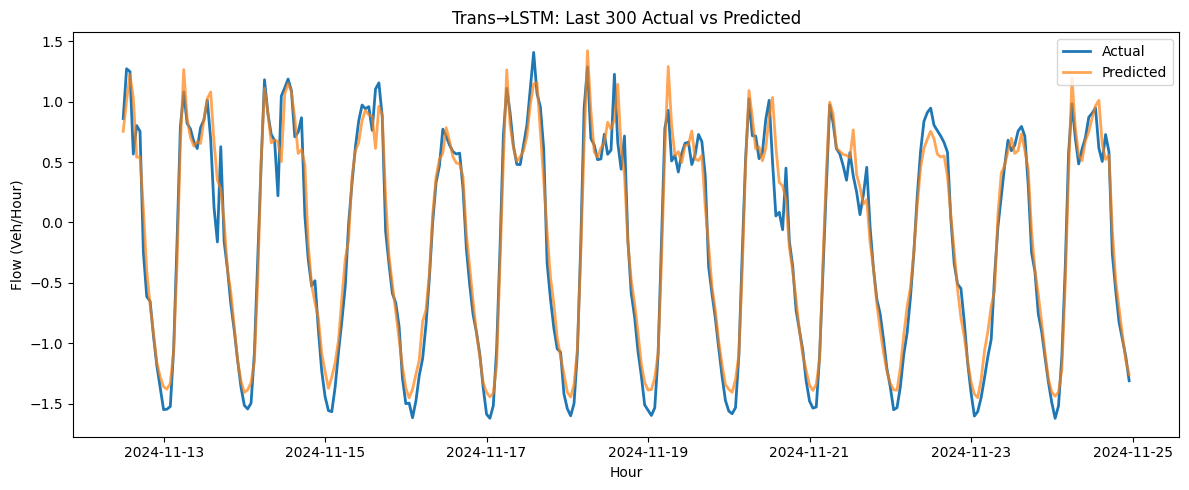

{'mae': 0.13859683275222778,
 'mse': 0.03246933966875076,
 'r2': 0.963114857673645,
 'train_curve': [0.2368462085723877,
  0.20518644154071808,
  0.16113032400608063,
  0.19126862287521362,
  0.17658382654190063,
  0.14740802347660065,
  0.1793583333492279,
  0.1636216789484024,
  0.1550910770893097,
  0.15565159916877747,
  0.15686683356761932,
  0.14656157791614532,
  0.1620110720396042,
  0.13700725138187408,
  0.14732730388641357,
  0.1260520964860916,
  0.14405381679534912,
  0.1782393604516983,
  0.15677693486213684,
  0.14059780538082123],
 'val_curve': [0.2245481163263321,
  0.1942206472158432,
  0.1650857776403427,
  0.19308482110500336,
  0.18037675321102142,
  0.1506911665201187,
  0.1947270631790161,
  0.18557660281658173,
  0.15922771394252777,
  0.1557772308588028,
  0.15774697065353394,
  0.1556900441646576,
  0.15601560473442078,
  0.15523134171962738,
  0.16370992362499237,
  0.1500539630651474,
  0.1545802354812622,
  0.17352966964244843,
  0.16293300688266754,
  0.14

In [ ]:
 run_single_model('Trans→LSTM')

CNN→LSTM Epoch 01: Train MAE 0.229, Val MAE 0.218
CNN→LSTM Epoch 02: Train MAE 0.178, Val MAE 0.175
CNN→LSTM Epoch 03: Train MAE 0.166, Val MAE 0.169
CNN→LSTM Epoch 04: Train MAE 0.184, Val MAE 0.178
CNN→LSTM Epoch 05: Train MAE 0.189, Val MAE 0.174
CNN→LSTM Epoch 06: Train MAE 0.157, Val MAE 0.160
CNN→LSTM Epoch 07: Train MAE 0.167, Val MAE 0.164
CNN→LSTM Epoch 08: Train MAE 0.183, Val MAE 0.171
CNN→LSTM Epoch 09: Train MAE 0.206, Val MAE 0.194
CNN→LSTM Epoch 10: Train MAE 0.146, Val MAE 0.153
CNN→LSTM Epoch 11: Train MAE 0.157, Val MAE 0.157
CNN→LSTM Epoch 12: Train MAE 0.145, Val MAE 0.152
CNN→LSTM Epoch 13: Train MAE 0.173, Val MAE 0.172
CNN→LSTM Epoch 14: Train MAE 0.169, Val MAE 0.172
CNN→LSTM Epoch 15: Train MAE 0.145, Val MAE 0.155
CNN→LSTM Epoch 16: Train MAE 0.187, Val MAE 0.187
CNN→LSTM Epoch 17: Train MAE 0.162, Val MAE 0.168
CNN→LSTM Epoch 18: Train MAE 0.151, Val MAE 0.161
CNN→LSTM Epoch 19: Train MAE 0.149, Val MAE 0.153
CNN→LSTM Epoch 20: Train MAE 0.159, Val MAE 0.165


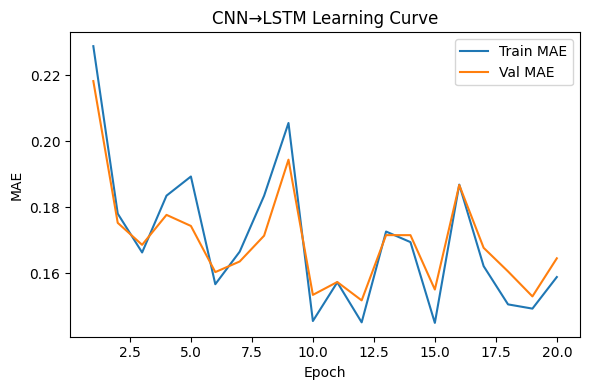

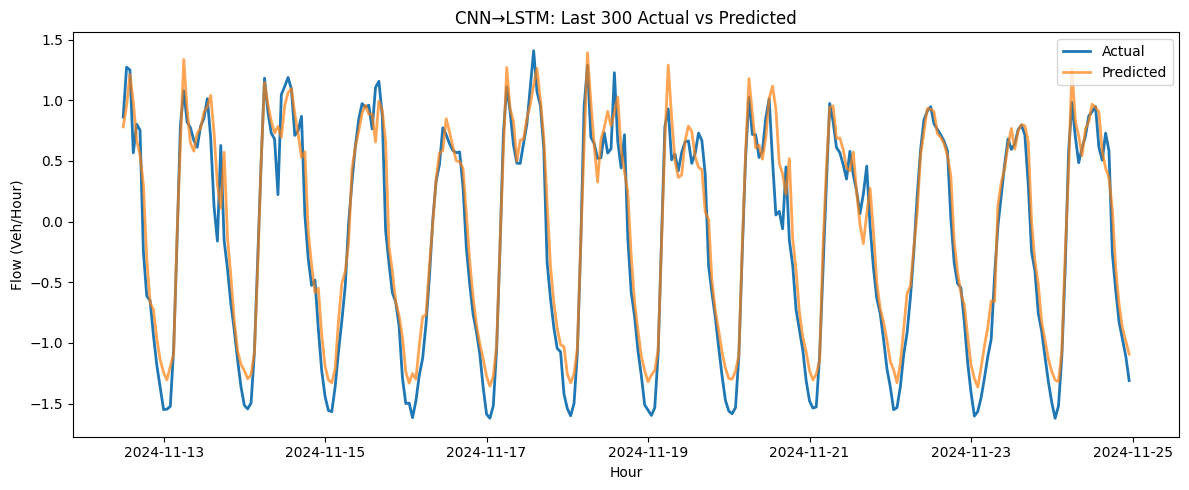

{'mae': 0.17589232325553894,
 'mse': 0.04883252829313278,
 'r2': 0.9445263147354126,
 'train_curve': [0.22875401377677917,
  0.17807169258594513,
  0.16632160544395447,
  0.18351322412490845,
  0.18930962681770325,
  0.15671412646770477,
  0.16656382381916046,
  0.18347559869289398,
  0.20550647377967834,
  0.14557769894599915,
  0.15728895366191864,
  0.14517460763454437,
  0.17265357077121735,
  0.16945533454418182,
  0.14501327276229858,
  0.1868639439344406,
  0.16218262910842896,
  0.15061160922050476,
  0.14933152496814728,
  0.15888716280460358],
 'val_curve': [0.218189537525177,
  0.17529018223285675,
  0.1686343103647232,
  0.1776992827653885,
  0.17434927821159363,
  0.1603832095861435,
  0.16359059512615204,
  0.17139649391174316,
  0.19440272450447083,
  0.1534886360168457,
  0.15738366544246674,
  0.15181884169578552,
  0.17156869173049927,
  0.17156395316123962,
  0.1551089882850647,
  0.18674109876155853,
  0.16772353649139404,
  0.16058382391929626,
  0.1530229151248932

In [ ]:
 run_single_model('CNN→LSTM')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# 1. Define the three hybrid models
class CNN_TCN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(64,32), tcn_filters=(32,32,32),
                 tcn_kernel=3, tcn_dilations=(1,2,4),
                 lstm_dim=128, dropout=0.2):
        super().__init__()
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch, c, 3, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)
        tcn_blocks = []
        for f,d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel-1)*d
            tcn_blocks += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim,1))
    def forward(self, x):
        z = self.cnn(x.permute(0,2,1))
        z = self.tcn(z)[...,:x.size(1)]
        z = z.permute(0,2,1)
        h,_ = self.lstm(z)
        return self.head(h[:,-1,:])

class TCN_Trans_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 tcn_filters=(64,64), tcn_kernel=3, tcn_dilations=(1,2),
                 trans_heads=4, trans_ff=128,
                 lstm_dim=64, dropout=0.2):
        super().__init__()
        layers, ch = [], in_dim
        for f,d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel-1)*d
            layers += [nn.Conv1d(ch,f,tcn_kernel,padding=pad,dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)
        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)
        self.ff = nn.Sequential(nn.LayerNorm(ch),
                                nn.Linear(ch, trans_ff), nn.ReLU(),
                                nn.Linear(trans_ff, ch))
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim,1))
    def forward(self, x):
        z = self.tcn(x.permute(0,2,1))[...,:x.size(1)].permute(0,2,1)
        z = z + self.pos
        a,_ = self.trans(z,z,z)
        y = self.ff(a+z)
        h,_ = self.lstm(y)
        return self.head(h[:,-1,:])

class CNN_Trans_TCN(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32,32), trans_heads=4, trans_ff=64,
                 tcn_filters=(64,32), tcn_kernel=3, tcn_dilations=(1,2),
                 dropout=0.2):
        super().__init__()
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch,c,3,padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)
        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)
        self.ff = nn.Sequential(nn.LayerNorm(ch),
                                nn.Linear(ch, trans_ff), nn.ReLU(),
                                nn.Linear(trans_ff, ch))
        tcn_blocks = []
        for f,d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel-1)*d
            tcn_blocks += [nn.Conv1d(ch,f,tcn_kernel,padding=pad,dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(ch,1))
    def forward(self, x):
        z = self.cnn(x.permute(0,2,1))[...,:x.size(1)].permute(0,2,1)
        z = z + self.pos
        a,_ = self.trans(z,z,z)
        z2 = self.ff(a+z).permute(0,2,1)
        z3 = self.tcn(z2)[...,:x.size(1)].permute(0,2,1)
        return self.head(z3[:,-1,:])

# Define the three hybrid models (same as before, simplified here for brevity)

# (Assume CNN_TCN_LSTM, TCN_Trans_LSTM, and CNN_Trans_TCN classes are already defined above)

# Optimized training loop with learning curves and weight decay
def train_with_curves(model, train_loader, val_loader, epochs=20, lr=5e-4, weight_decay=1e-4):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.L1Loss()
    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")
    return model, train_mae, val_mae

# Loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

def run_model_by_name(name, epochs=20):
    print(f"\nTraining {name}...")

    model_dict = {
        "CNN→TCN→LSTM": CNN_TCN_LSTM(
            train_ds.X.shape[2], train_ds.X.shape[1],
            cnn_ch=(32, 16),
            tcn_filters=(32, 16),
            tcn_kernel=5,
            tcn_dilations=(1, 2, 4),
            lstm_dim=64,
            dropout=0.7
        ),
        "TCN→Trans→LSTM": TCN_Trans_LSTM(
            in_dim=train_ds.X.shape[2],
            seq_len=train_ds.X.shape[1],
            tcn_filters=(64, 32),
            tcn_kernel=4,
            tcn_dilations=(1,2,4),
            trans_heads=4,
            trans_ff=32,
            lstm_dim=16,
            dropout=0.7
        ),
        "CNN→Trans→TCN": CNN_Trans_TCN(
            train_ds.X.shape[2], train_ds.X.shape[1],
            cnn_ch=(32, 16),
            trans_heads=2,
            trans_ff=128,
            tcn_filters=(32, 16),
            tcn_kernel=3,
            tcn_dilations=(1, 2, 4),
            dropout=0.5
        )
    }

    model = model_dict[name]
    model, train_mae, val_mae = train_with_curves(model, train_loader, val_loader, epochs=epochs)

    # Evaluate
    te_mae, preds, trues = eval_model(model, test_loader)
    te_mse = mean_squared_error(trues, preds)
    te_r2 = r2_score(trues, preds)

    print(f"\n{name} Test MAE: {te_mae:.3f}")
    print(f"{name} Test MSE: {te_mse:.3f}")
    print(f"{name} Test R²:  {te_r2:.3f}")

    # Learning curve
    plt.figure(figsize=(6,4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Epoch"); plt.ylabel("MAE")
    plt.legend(); plt.tight_layout(); plt.show()

    # Time-series plot
    seq_len = X_train.shape[1]
    n_seq = len(X_seq)
    i_val = int(0.85 * n_seq)
    start = seq_len + i_val
    hours = df_filtered["Hour"].iloc[start:start + len(trues)].reset_index(drop=True)

    plt.figure(figsize=(12,5))
    plt.plot(hours[-300:], trues[-300:], label="Actual", linewidth=2)
    plt.plot(hours[-300:], preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Hour"); plt.ylabel("Flow (Veh/Hour)")
    plt.title(f"{name}: Actual vs Predicted (Last 300 Points)")
    plt.legend(); plt.tight_layout(); plt.show()

    return {
        'mae': te_mae,
        'mse': te_mse,
        'r2': te_r2,
        'train_curve': train_mae,
        'val_curve': val_mae,
        'preds': preds,
        'trues': trues
    }


In [ ]:
train_ds


Training CNN→TCN→LSTM...
Epoch 01 | Train MAE: 0.2716 | Val MAE: 0.2764
Epoch 02 | Train MAE: 0.1939 | Val MAE: 0.2121
Epoch 03 | Train MAE: 0.1469 | Val MAE: 0.1739
Epoch 04 | Train MAE: 0.1494 | Val MAE: 0.1582
Epoch 05 | Train MAE: 0.1435 | Val MAE: 0.1584
Epoch 06 | Train MAE: 0.1278 | Val MAE: 0.1522
Epoch 07 | Train MAE: 0.1107 | Val MAE: 0.1487
Epoch 08 | Train MAE: 0.1150 | Val MAE: 0.1452
Epoch 09 | Train MAE: 0.1155 | Val MAE: 0.1474
Epoch 10 | Train MAE: 0.1348 | Val MAE: 0.1480
Epoch 11 | Train MAE: 0.1051 | Val MAE: 0.1293
Epoch 12 | Train MAE: 0.0972 | Val MAE: 0.1343
Epoch 13 | Train MAE: 0.1132 | Val MAE: 0.1370
Epoch 14 | Train MAE: 0.0939 | Val MAE: 0.1388
Epoch 15 | Train MAE: 0.0968 | Val MAE: 0.1337
Epoch 16 | Train MAE: 0.0959 | Val MAE: 0.1243
Epoch 17 | Train MAE: 0.1243 | Val MAE: 0.1293
Epoch 18 | Train MAE: 0.1033 | Val MAE: 0.1266
Epoch 19 | Train MAE: 0.1087 | Val MAE: 0.1267
Epoch 20 | Train MAE: 0.1076 | Val MAE: 0.1359

CNN→TCN→LSTM Test MAE: 0.129
CNN→

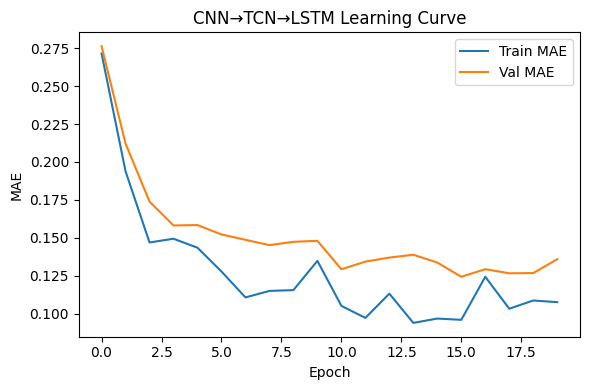

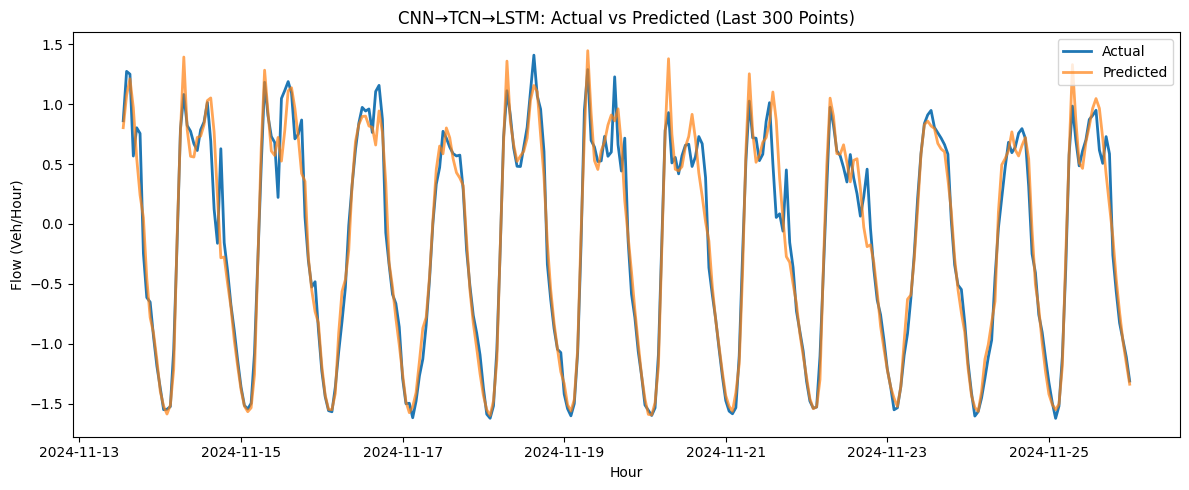

{'mae': 0.12922044098377228,
 'mse': 0.033629078418016434,
 'r2': 0.9617974162101746,
 'train_curve': [0.27156248688697815,
  0.19385290145874023,
  0.1469397246837616,
  0.1493932157754898,
  0.1434609591960907,
  0.1277887225151062,
  0.11070659756660461,
  0.11498600244522095,
  0.11552245914936066,
  0.1348063051700592,
  0.10514872521162033,
  0.0971762165427208,
  0.11316941678524017,
  0.09390758723020554,
  0.09676714241504669,
  0.09591928869485855,
  0.12431187927722931,
  0.10326502472162247,
  0.10866192728281021,
  0.10757517069578171],
 'val_curve': [0.2763737142086029,
  0.2121339589357376,
  0.1738862544298172,
  0.15815916657447815,
  0.15841050446033478,
  0.15222357213497162,
  0.14868392050266266,
  0.14519090950489044,
  0.14735352993011475,
  0.1480226367712021,
  0.12926249206066132,
  0.13429123163223267,
  0.13697569072246552,
  0.1388411968946457,
  0.13368600606918335,
  0.12430596351623535,
  0.12930665910243988,
  0.12661252915859222,
  0.12674333155155182,

In [ ]:
run_model_by_name("CNN→TCN→LSTM")


Training TCN→Trans→LSTM...
Epoch 01 | Train MAE: 0.2699 | Val MAE: 0.2814
Epoch 02 | Train MAE: 0.2253 | Val MAE: 0.2331
Epoch 03 | Train MAE: 0.1483 | Val MAE: 0.1802
Epoch 04 | Train MAE: 0.1679 | Val MAE: 0.1654
Epoch 05 | Train MAE: 0.1466 | Val MAE: 0.1555
Epoch 06 | Train MAE: 0.1445 | Val MAE: 0.1629
Epoch 07 | Train MAE: 0.1539 | Val MAE: 0.1635
Epoch 08 | Train MAE: 0.1513 | Val MAE: 0.1609
Epoch 09 | Train MAE: 0.1235 | Val MAE: 0.1457
Epoch 10 | Train MAE: 0.1663 | Val MAE: 0.1613
Epoch 11 | Train MAE: 0.1290 | Val MAE: 0.1539
Epoch 12 | Train MAE: 0.1409 | Val MAE: 0.1537
Epoch 13 | Train MAE: 0.1324 | Val MAE: 0.1499
Epoch 14 | Train MAE: 0.1437 | Val MAE: 0.1527
Epoch 15 | Train MAE: 0.1788 | Val MAE: 0.1642
Epoch 16 | Train MAE: 0.1468 | Val MAE: 0.1538
Epoch 17 | Train MAE: 0.1357 | Val MAE: 0.1456
Epoch 18 | Train MAE: 0.1596 | Val MAE: 0.1606
Epoch 19 | Train MAE: 0.1425 | Val MAE: 0.1548
Epoch 20 | Train MAE: 0.1222 | Val MAE: 0.1525

TCN→Trans→LSTM Test MAE: 0.137


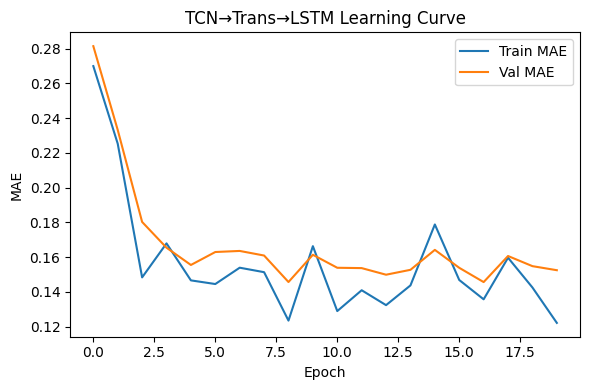

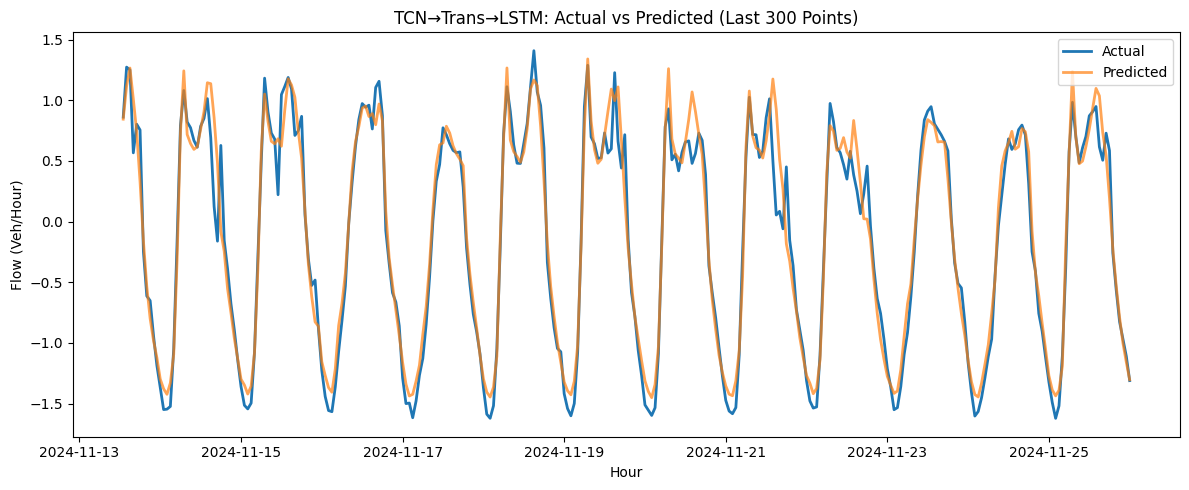

{'mae': 0.13690519332885742,
 'mse': 0.033430155366659164,
 'r2': 0.9620233774185181,
 'train_curve': [0.2698843479156494,
  0.2252558320760727,
  0.14833366870880127,
  0.16789031028747559,
  0.14661137759685516,
  0.14450986683368683,
  0.15390552580356598,
  0.151328444480896,
  0.12346921861171722,
  0.16629236936569214,
  0.12895284593105316,
  0.1409381926059723,
  0.13236233592033386,
  0.14372184872627258,
  0.17877517640590668,
  0.1468321532011032,
  0.1357145756483078,
  0.159645676612854,
  0.1425226330757141,
  0.12215524166822433],
 'val_curve': [0.2813572287559509,
  0.2331436425447464,
  0.18023651838302612,
  0.16541486978530884,
  0.1554749757051468,
  0.16293294727802277,
  0.16354918479919434,
  0.16090470552444458,
  0.14566560089588165,
  0.1613311618566513,
  0.15386536717414856,
  0.15367187559604645,
  0.14987070858478546,
  0.15268810093402863,
  0.1641613245010376,
  0.15384306013584137,
  0.14563454687595367,
  0.16062837839126587,
  0.15479855239391327,
  0

In [ ]:
run_model_by_name("TCN→Trans→LSTM")


Training CNN→Trans→TCN...
Epoch 01 | Train MAE: 0.2280 | Val MAE: 0.2404
Epoch 02 | Train MAE: 0.2079 | Val MAE: 0.2144
Epoch 03 | Train MAE: 0.1870 | Val MAE: 0.2111
Epoch 04 | Train MAE: 0.1821 | Val MAE: 0.1890
Epoch 05 | Train MAE: 0.1731 | Val MAE: 0.1763
Epoch 06 | Train MAE: 0.2088 | Val MAE: 0.1934
Epoch 07 | Train MAE: 0.1796 | Val MAE: 0.1757
Epoch 08 | Train MAE: 0.1921 | Val MAE: 0.1803
Epoch 09 | Train MAE: 0.1809 | Val MAE: 0.1754
Epoch 10 | Train MAE: 0.1915 | Val MAE: 0.1778
Epoch 11 | Train MAE: 0.1722 | Val MAE: 0.1684
Epoch 12 | Train MAE: 0.2075 | Val MAE: 0.1921
Epoch 13 | Train MAE: 0.1763 | Val MAE: 0.1710
Epoch 14 | Train MAE: 0.1933 | Val MAE: 0.1745
Epoch 15 | Train MAE: 0.1559 | Val MAE: 0.1518
Epoch 16 | Train MAE: 0.1686 | Val MAE: 0.1673
Epoch 17 | Train MAE: 0.1728 | Val MAE: 0.1611
Epoch 18 | Train MAE: 0.1810 | Val MAE: 0.1740
Epoch 19 | Train MAE: 0.1816 | Val MAE: 0.1710
Epoch 20 | Train MAE: 0.1756 | Val MAE: 0.1679

CNN→Trans→TCN Test MAE: 0.179
CN

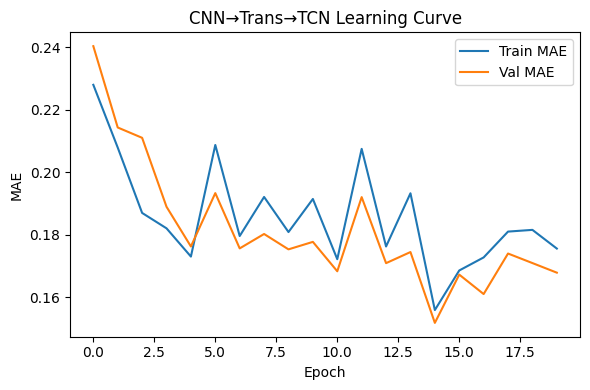

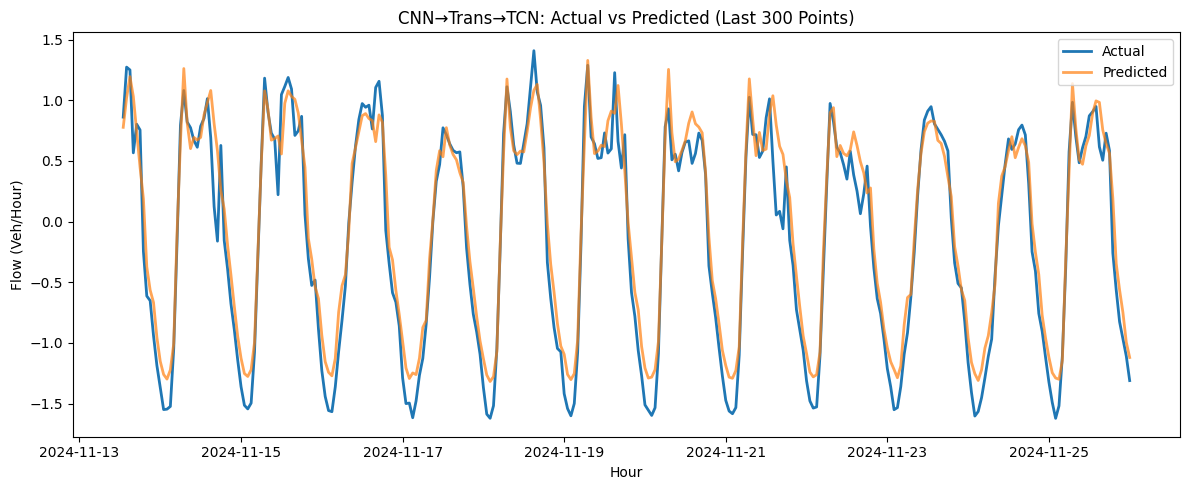

{'mae': 0.17851784825325012,
 'mse': 0.04895491525530815,
 'r2': 0.9443873167037964,
 'train_curve': [0.22800827026367188,
  0.20793592929840088,
  0.18701831996440887,
  0.18209388852119446,
  0.17305384576320648,
  0.20876115560531616,
  0.17962896823883057,
  0.19212915003299713,
  0.18089984357357025,
  0.19148588180541992,
  0.17221516370773315,
  0.20751984417438507,
  0.17628337442874908,
  0.1933068484067917,
  0.15594008564949036,
  0.16860592365264893,
  0.1727805882692337,
  0.18104714155197144,
  0.1815968155860901,
  0.17561987042427063],
 'val_curve': [0.2403797060251236,
  0.21435995399951935,
  0.21105408668518066,
  0.1889960765838623,
  0.17628443241119385,
  0.1933610588312149,
  0.17567095160484314,
  0.18028005957603455,
  0.1753646582365036,
  0.1777573525905609,
  0.16835202276706696,
  0.19207553565502167,
  0.17095044255256653,
  0.17450278997421265,
  0.15183529257774353,
  0.16728074848651886,
  0.1610603779554367,
  0.1740277260541916,
  0.1709744930267334,


In [ ]:
run_model_by_name("CNN→Trans→TCN")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume df_filtered is already loaded in the environment
df = df_filtered.copy()

# 1. Select numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()
df_num = df[num_cols].copy()

# 2. Drop low-variance features
vt = VarianceThreshold(threshold=0.01)
vt.fit(df_num)
low_var_cols = [col for col, keep in zip(df_num.columns, vt.get_support()) if not keep]
df_num.drop(columns=low_var_cols, inplace=True)

# 3. Drop highly correlated features
corr_matrix = df_num.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper.columns if any(upper[col] > 0.95)]
df_num.drop(columns=high_corr_cols, inplace=True)

# 4. Remove multicollinearity with VIF
X_vif = df_num.drop(columns=['Flow (Veh/Hour)'], errors='ignore')
while True:
    vif_df = pd.DataFrame()
    vif_df["feature"] = X_vif.columns
    vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    max_vif = vif_df["VIF"].max()
    if max_vif > 5:
        drop_feature = vif_df.sort_values("VIF", ascending=False).iloc[0]["feature"]
        X_vif = X_vif.drop(columns=[drop_feature])
    else:
        break

features = X_vif.columns.tolist()
target = "Flow (Veh/Hour)"
df_reg = df[features + [target]].dropna()

X = df_reg[features].values
y = df_reg[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# 6. Train regression models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=3)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test_scaled, y_pred)
    results[name] = mae



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test_scaled, y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2  = r2_score(y_test_scaled, y_pred)

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "R2":  r2
    }

# Display results
for name, metrics in results.items():
    print(f"{name} → MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")




LinearRegression → MAE: 0.6637, MSE: 0.6305, R2: 0.2423
DecisionTree → MAE: 0.2959, MSE: 0.1846, R2: 0.7781
RandomForest → MAE: 0.2734, MSE: 0.1666, R2: 0.7998


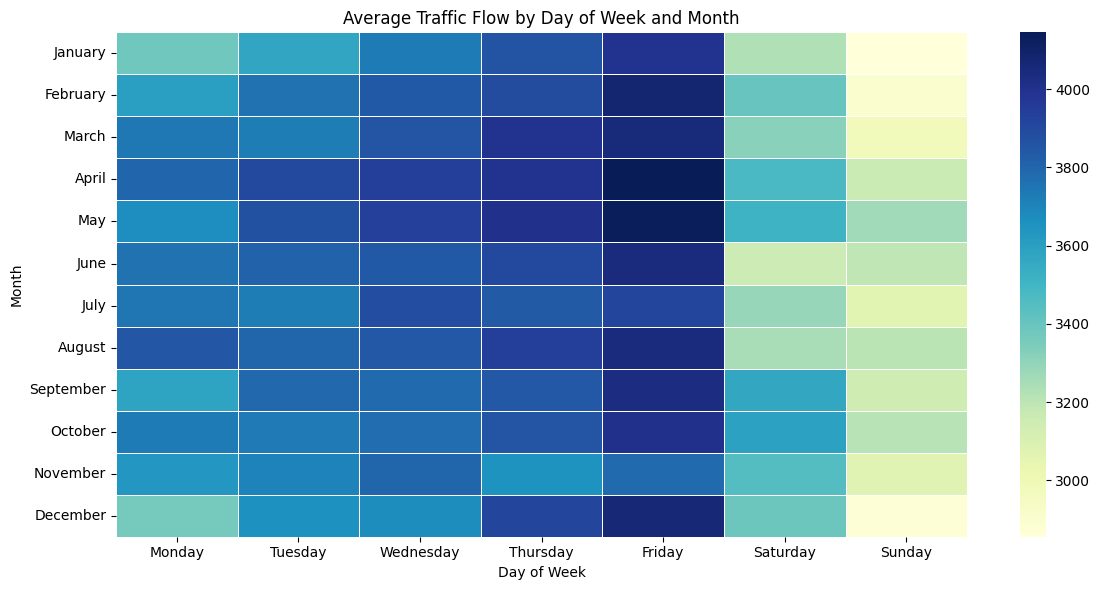

In [ ]:
# Re-import necessary libraries after kernel reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (reloading due to kernel reset)
df_filtered_1 = df_filtered.copy()

# Convert 'Hour' to datetime
df_filtered_1['Hour'] = pd.to_datetime(df_filtered_1['Hour'])

# Extract day of week and month
df_filtered_1['DayOfWeek'] = df_filtered_1['Hour'].dt.day_name()
df_filtered_1['Month'] = df_filtered_1['Hour'].dt.month_name()

# Group by Month and Day of Week and compute average Flow
pivot_data = df_filtered_1.groupby(['Month', 'DayOfWeek'])['Flow (Veh/Hour)'].mean().unstack()

# Reorder days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = pivot_data[day_order]

# Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_data = pivot_data.reindex(month_order)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="YlGnBu", annot=False, fmt=".0f", linewidths=.5)
plt.title("Average Traffic Flow by Day of Week and Month")
plt.xlabel("Day of Week")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


Epoch 01 | Train MAE: 0.3011 | Val MAE: 0.2987
Epoch 02 | Train MAE: 0.2472 | Val MAE: 0.2520
Epoch 03 | Train MAE: 0.1943 | Val MAE: 0.1971
Epoch 04 | Train MAE: 0.1696 | Val MAE: 0.1634
Epoch 05 | Train MAE: 0.1303 | Val MAE: 0.1534
Epoch 06 | Train MAE: 0.1685 | Val MAE: 0.1578
Epoch 07 | Train MAE: 0.1663 | Val MAE: 0.1658
Epoch 08 | Train MAE: 0.1687 | Val MAE: 0.1533
Epoch 09 | Train MAE: 0.1260 | Val MAE: 0.1405
Epoch 10 | Train MAE: 0.1339 | Val MAE: 0.1414
Epoch 11 | Train MAE: 0.1561 | Val MAE: 0.1577
Epoch 12 | Train MAE: 0.1375 | Val MAE: 0.1455
Epoch 13 | Train MAE: 0.1348 | Val MAE: 0.1385
Epoch 14 | Train MAE: 0.1351 | Val MAE: 0.1380
Epoch 15 | Train MAE: 0.1339 | Val MAE: 0.1476
Epoch 16 | Train MAE: 0.1112 | Val MAE: 0.1399
Epoch 17 | Train MAE: 0.1097 | Val MAE: 0.1306
Epoch 18 | Train MAE: 0.1210 | Val MAE: 0.1416
Epoch 19 | Train MAE: 0.1276 | Val MAE: 0.1383
Epoch 20 | Train MAE: 0.1328 | Val MAE: 0.1361
Epoch 21 | Train MAE: 0.1131 | Val MAE: 0.1345
Epoch 22 | Tr

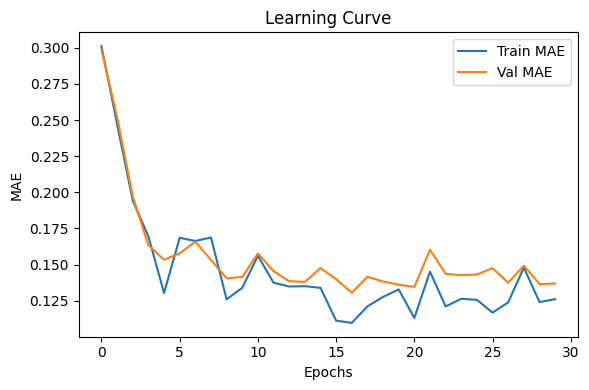


Test MAE: 0.1581
Test MSE: 0.0439
Test R²:  0.9502


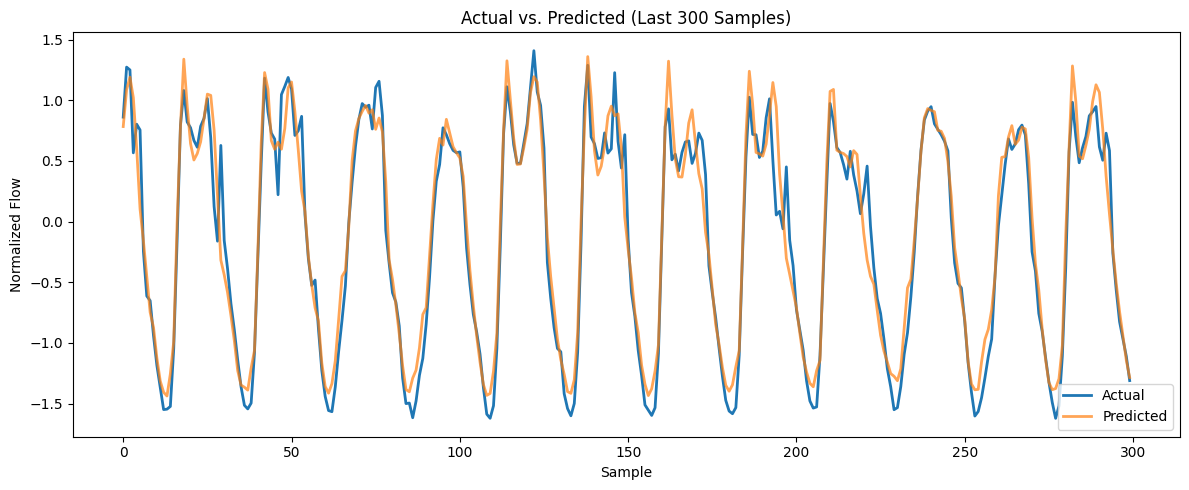

Final Test Metrics:
MAE: 0.15814362466335297
MSE: 0.043869949877262115
R² : 0.9501638412475586


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN→TCN→LSTM Model ==========
class CNN_TCN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16), tcn_filters=(32, 16),
                 tcn_kernel=5, tcn_dilations=(1, 2, 4),
                 lstm_dim=64, dropout=0.7):
        super().__init__()
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch, c, 3, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)
        tcn_blocks = []
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            tcn_blocks += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1))
        z = self.tcn(z)[..., :x.size(1)]
        z = z.permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Greenshields FD Function (Normalized) ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled


# ========== Custom FD-Informed Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.05, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.05):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
# Create model instance with specified architecture
model = CNN_TCN_LSTM(
    in_dim=train_ds.X.shape[2],        # number of features (e.g., 1 for flow)
    seq_len=train_ds.X.shape[1],       # sequence length (e.g., 24 for hourly)
    cnn_ch=(32, 16),                   # CNN channel sizes
    tcn_filters=(32, 16),              # TCN filter sizes
    tcn_kernel=5,                      # TCN kernel size
    tcn_dilations=(1, 2, 4),           # TCN dilation pattern
    lstm_dim=64,                       # LSTM hidden size
    dropout=0.85                        # Dropout rate
)

# Train model with FD-informed loss
model, metrics = train_fd_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4,
    alpha=0.12   # FD loss weight (adjust as needed)
)

# Access test metrics
print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])



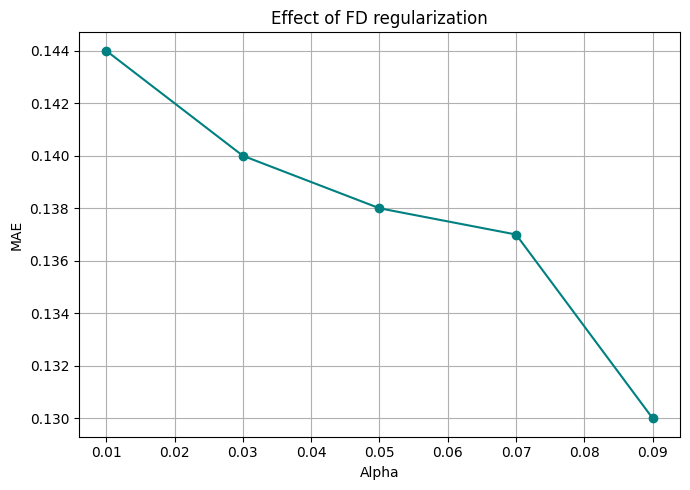

In [ ]:
import matplotlib.pyplot as plt

# Data
alpha_values = [0.01, 0.03, 0.05, 0.07, 0.09]
mae_values = [0.144, 0.140, 0.138, 0.137, 0.130]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, mae_values, marker='o', linestyle='-', color='teal')
plt.title("Effect of FD regularization")
plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#CNN_TCN_LSTM with out dynamic

Epoch 01 | Train MAE: 0.2786 | Val MAE: 0.3187
Epoch 02 | Train MAE: 0.2427 | Val MAE: 0.2785
Epoch 03 | Train MAE: 0.2012 | Val MAE: 0.2577
Epoch 04 | Train MAE: 0.1641 | Val MAE: 0.2184
Epoch 05 | Train MAE: 0.1631 | Val MAE: 0.2011
Epoch 06 | Train MAE: 0.1516 | Val MAE: 0.1896
Epoch 07 | Train MAE: 0.1546 | Val MAE: 0.1839
Epoch 08 | Train MAE: 0.1491 | Val MAE: 0.1746
Epoch 09 | Train MAE: 0.1465 | Val MAE: 0.1633
Epoch 10 | Train MAE: 0.1331 | Val MAE: 0.1539
Epoch 11 | Train MAE: 0.1441 | Val MAE: 0.1495
Epoch 12 | Train MAE: 0.1240 | Val MAE: 0.1436
Epoch 13 | Train MAE: 0.1488 | Val MAE: 0.1533
Epoch 14 | Train MAE: 0.1036 | Val MAE: 0.1373
Epoch 15 | Train MAE: 0.1365 | Val MAE: 0.1527
Epoch 16 | Train MAE: 0.1380 | Val MAE: 0.1529
Epoch 17 | Train MAE: 0.1476 | Val MAE: 0.1648
Epoch 18 | Train MAE: 0.1168 | Val MAE: 0.1486
Epoch 19 | Train MAE: 0.1232 | Val MAE: 0.1416
Epoch 20 | Train MAE: 0.1176 | Val MAE: 0.1441
Epoch 21 | Train MAE: 0.1373 | Val MAE: 0.1509
Epoch 22 | Tr

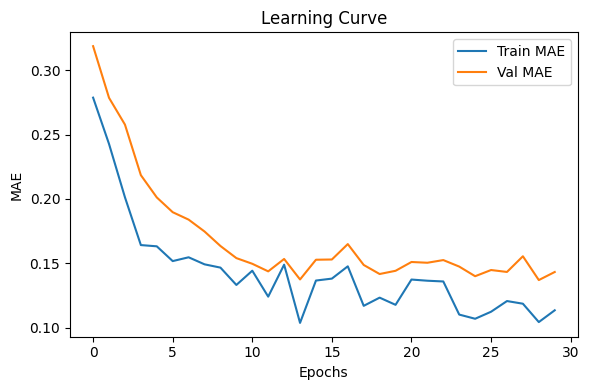


Test MAE: 0.1343
Test MSE: 0.0335
Test R²:  0.9619


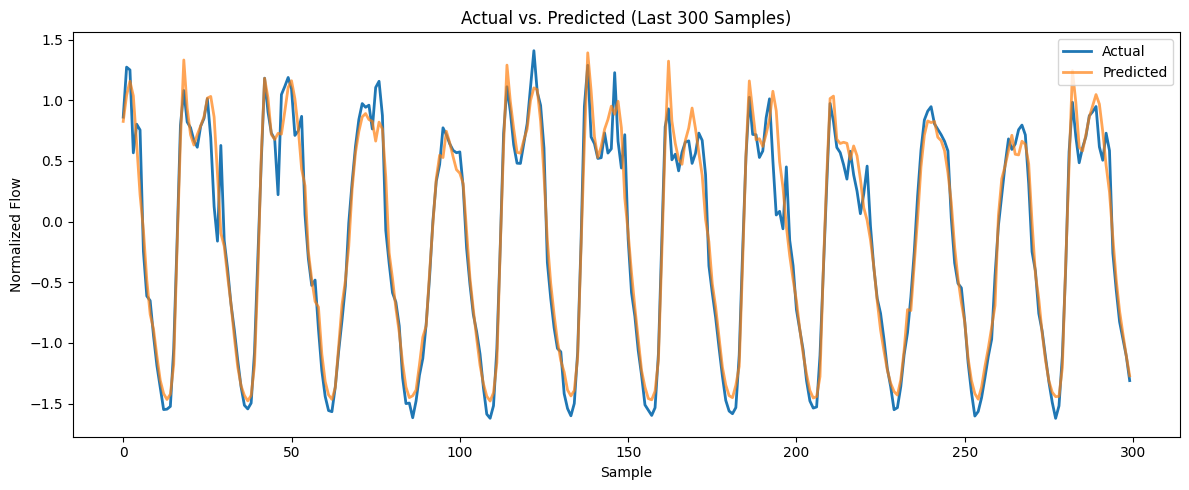

Final Test Metrics:
MAE: 0.13432058691978455
MSE: 0.03352285176515579
R² : 0.9619181156158447


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN→TCN→LSTM Model ==========
class CNN_TCN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16), tcn_filters=(32, 16),
                 tcn_kernel=5, tcn_dilations=(1, 2, 4),
                 lstm_dim=64, dropout=0.7):
        super().__init__()
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch, c, 3, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)
        tcn_blocks = []
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            tcn_blocks += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1))
        z = self.tcn(z)[..., :x.size(1)]
        z = z.permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Standard MAE Loss ==========
class MAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = MAELoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = CNN_TCN_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    cnn_ch=(32, 16),
    tcn_filters=(32, 16),
    tcn_kernel=5,
    tcn_dilations=(1, 2, 4),
    lstm_dim=64,
    dropout=0.85
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


Epoch 01 | Train MAE: 0.2867 | Val MAE: 0.2905
Epoch 02 | Train MAE: 0.1755 | Val MAE: 0.2085
Epoch 03 | Train MAE: 0.2175 | Val MAE: 0.1985
Epoch 04 | Train MAE: 0.1589 | Val MAE: 0.1797
Epoch 05 | Train MAE: 0.1627 | Val MAE: 0.1796
Epoch 06 | Train MAE: 0.1486 | Val MAE: 0.1662
Epoch 07 | Train MAE: 0.1811 | Val MAE: 0.1752
Epoch 08 | Train MAE: 0.1498 | Val MAE: 0.1590
Epoch 09 | Train MAE: 0.1332 | Val MAE: 0.1595
Epoch 10 | Train MAE: 0.1106 | Val MAE: 0.1492
Epoch 11 | Train MAE: 0.1534 | Val MAE: 0.1531
Epoch 12 | Train MAE: 0.1299 | Val MAE: 0.1452
Epoch 13 | Train MAE: 0.1305 | Val MAE: 0.1488
Epoch 14 | Train MAE: 0.1558 | Val MAE: 0.1552
Epoch 15 | Train MAE: 0.1436 | Val MAE: 0.1529
Epoch 16 | Train MAE: 0.1316 | Val MAE: 0.1434
Epoch 17 | Train MAE: 0.1512 | Val MAE: 0.1607
Epoch 18 | Train MAE: 0.1338 | Val MAE: 0.1486
Epoch 19 | Train MAE: 0.1393 | Val MAE: 0.1515
Epoch 20 | Train MAE: 0.1178 | Val MAE: 0.1414
Epoch 21 | Train MAE: 0.1507 | Val MAE: 0.1446
Epoch 22 | Tr

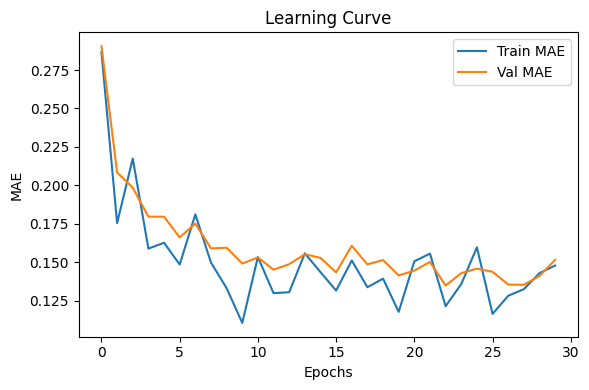


Test MAE: 0.1766
Test MSE: 0.0498
Test R²:  0.9434


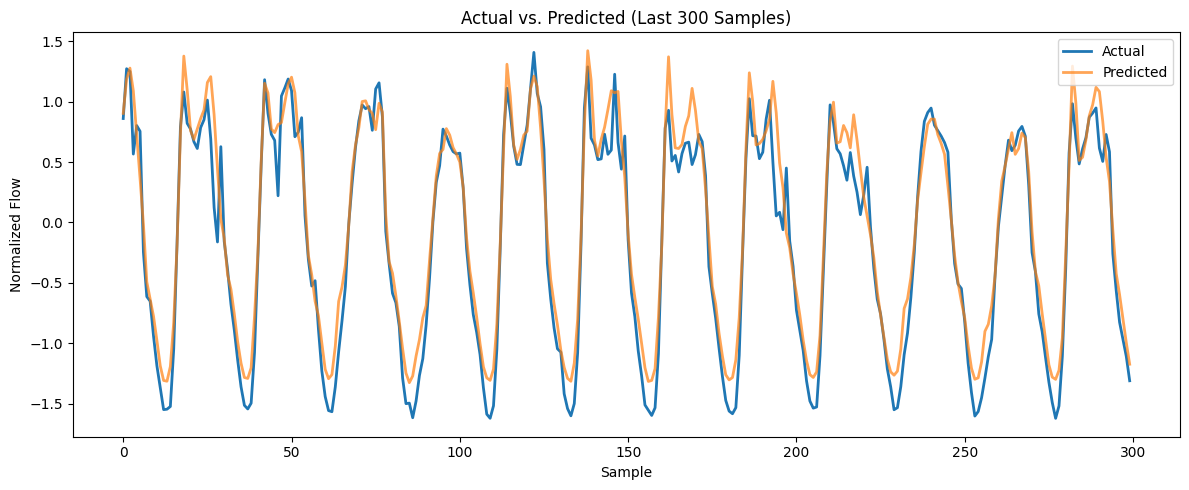

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== TCN→Transformer→LSTM Model ==========
class TCN_Trans_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 tcn_filters=(64, 64), tcn_kernel=3, tcn_dilations=(1, 2),
                 trans_heads=4, trans_ff=128,
                 lstm_dim=64, dropout=0.2):
        super().__init__()
        layers, ch = [], in_dim
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            layers += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)

        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)

        self.ff = nn.Sequential(
            nn.LayerNorm(ch),
            nn.Linear(ch, trans_ff), nn.ReLU(),
            nn.Linear(trans_ff, ch)
        )

        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.tcn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        z = z + self.pos
        a, _ = self.trans(z, z, z)
        y = self.ff(a + z)
        h, _ = self.lstm(y)
        return self.head(h[:, -1, :])

# ========== Greenshields FD Function (Normalized) ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled

# ========== Custom FD-Informed Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.01, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = TCN_Trans_LSTM(
     in_dim=train_ds.X.shape[2],
     seq_len=train_ds.X.shape[1],
     tcn_filters=(64, 32),
     tcn_kernel=4,
     tcn_dilations=(1, 2, 4),
     trans_heads=4,
     trans_ff=32,
     lstm_dim=16,
     dropout=0.7
 )
model, metrics = train_fd_model(
     model=model,
     train_loader=train_loader,
     val_loader=val_loader,
     test_loader=test_loader,
     epochs=30,
     lr=5e-4,
     alpha=0.01
 )


In [ ]:
#tcn-trans-lstm with out

Epoch 01 | Train MAE: 0.2594 | Val MAE: 0.2653
Epoch 02 | Train MAE: 0.1907 | Val MAE: 0.2019
Epoch 03 | Train MAE: 0.1723 | Val MAE: 0.1913
Epoch 04 | Train MAE: 0.1710 | Val MAE: 0.1783
Epoch 05 | Train MAE: 0.1296 | Val MAE: 0.1686
Epoch 06 | Train MAE: 0.1643 | Val MAE: 0.1646
Epoch 07 | Train MAE: 0.1401 | Val MAE: 0.1635
Epoch 08 | Train MAE: 0.1741 | Val MAE: 0.1714
Epoch 09 | Train MAE: 0.1715 | Val MAE: 0.1641
Epoch 10 | Train MAE: 0.1683 | Val MAE: 0.1586
Epoch 11 | Train MAE: 0.1544 | Val MAE: 0.1613
Epoch 12 | Train MAE: 0.1689 | Val MAE: 0.1597
Epoch 13 | Train MAE: 0.1647 | Val MAE: 0.1553
Epoch 14 | Train MAE: 0.1611 | Val MAE: 0.1584
Epoch 15 | Train MAE: 0.1263 | Val MAE: 0.1448
Epoch 16 | Train MAE: 0.1342 | Val MAE: 0.1470
Epoch 17 | Train MAE: 0.1463 | Val MAE: 0.1585
Epoch 18 | Train MAE: 0.1097 | Val MAE: 0.1519
Epoch 19 | Train MAE: 0.1290 | Val MAE: 0.1491
Epoch 20 | Train MAE: 0.1447 | Val MAE: 0.1494
Epoch 21 | Train MAE: 0.1766 | Val MAE: 0.1646
Epoch 22 | Tr

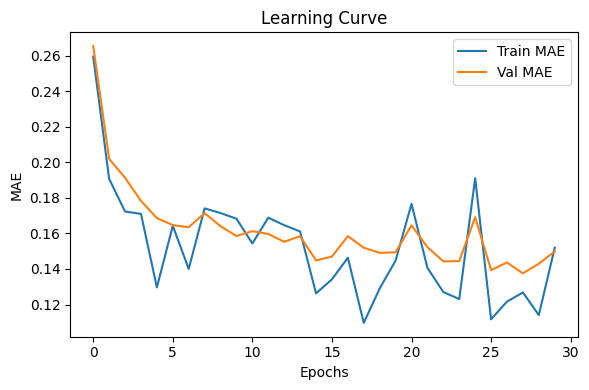


Test MAE: 0.1555
Test MSE: 0.0384
Test R²:  0.9564


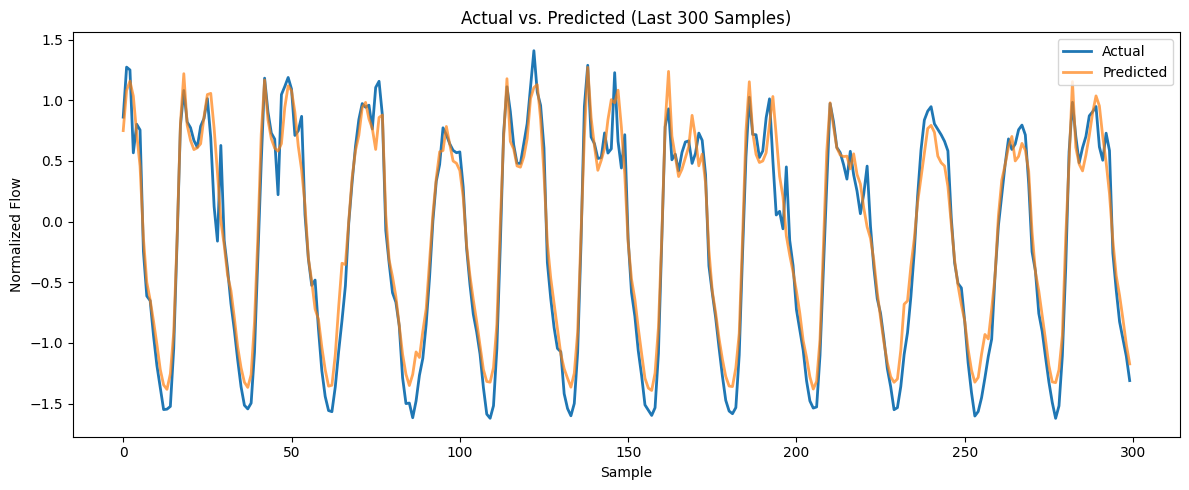

Final Test Metrics:
MAE: 0.1554732471704483
MSE: 0.03837459534406662
R² : 0.9564065337181091


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== TCN→Transformer→LSTM Model ==========
class TCN_Trans_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 tcn_filters=(64, 64), tcn_kernel=3, tcn_dilations=(1, 2),
                 trans_heads=4, trans_ff=128,
                 lstm_dim=64, dropout=0.2):
        super().__init__()
        layers, ch = [], in_dim
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            layers += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)

        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)

        self.ff = nn.Sequential(
            nn.LayerNorm(ch),
            nn.Linear(ch, trans_ff), nn.ReLU(),
            nn.Linear(trans_ff, ch)
        )

        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.tcn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        z = z + self.pos
        a, _ = self.trans(z, z, z)
        y = self.ff(a + z)
        h, _ = self.lstm(y)
        return self.head(h[:, -1, :])

# ========== Standard MAE Loss ==========
class MAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = MAELoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = TCN_Trans_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    tcn_filters=(64, 32),
    tcn_kernel=4,
    tcn_dilations=(1, 2, 4),
    trans_heads=4,
    trans_ff=32,
    lstm_dim=16,
    dropout=0.7
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


Epoch 01 | Train MAE: 0.3192 | Val MAE: 0.3361
Epoch 02 | Train MAE: 0.2255 | Val MAE: 0.2559
Epoch 03 | Train MAE: 0.2141 | Val MAE: 0.2296
Epoch 04 | Train MAE: 0.1698 | Val MAE: 0.2260
Epoch 05 | Train MAE: 0.1865 | Val MAE: 0.2563
Epoch 06 | Train MAE: 0.1969 | Val MAE: 0.2332
Epoch 07 | Train MAE: 0.1658 | Val MAE: 0.2614
Epoch 08 | Train MAE: 0.1662 | Val MAE: 0.2412
Epoch 09 | Train MAE: 0.1627 | Val MAE: 0.2439
Epoch 10 | Train MAE: 0.1830 | Val MAE: 0.2531
Epoch 11 | Train MAE: 0.1665 | Val MAE: 0.2312
Epoch 12 | Train MAE: 0.1694 | Val MAE: 0.2421
Epoch 13 | Train MAE: 0.1725 | Val MAE: 0.2384
Epoch 14 | Train MAE: 0.1571 | Val MAE: 0.2297
Epoch 15 | Train MAE: 0.1595 | Val MAE: 0.2308
Epoch 16 | Train MAE: 0.1618 | Val MAE: 0.2283
Epoch 17 | Train MAE: 0.1585 | Val MAE: 0.2186
Epoch 18 | Train MAE: 0.1475 | Val MAE: 0.2255
Epoch 19 | Train MAE: 0.1336 | Val MAE: 0.2204
Epoch 20 | Train MAE: 0.1344 | Val MAE: 0.2037
Epoch 21 | Train MAE: 0.1471 | Val MAE: 0.2101
Epoch 22 | Tr

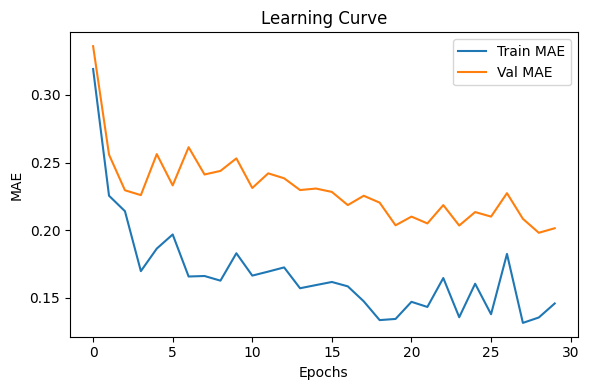


Test MAE: 0.1708
Test MSE: 0.0521
Test R²:  0.9408


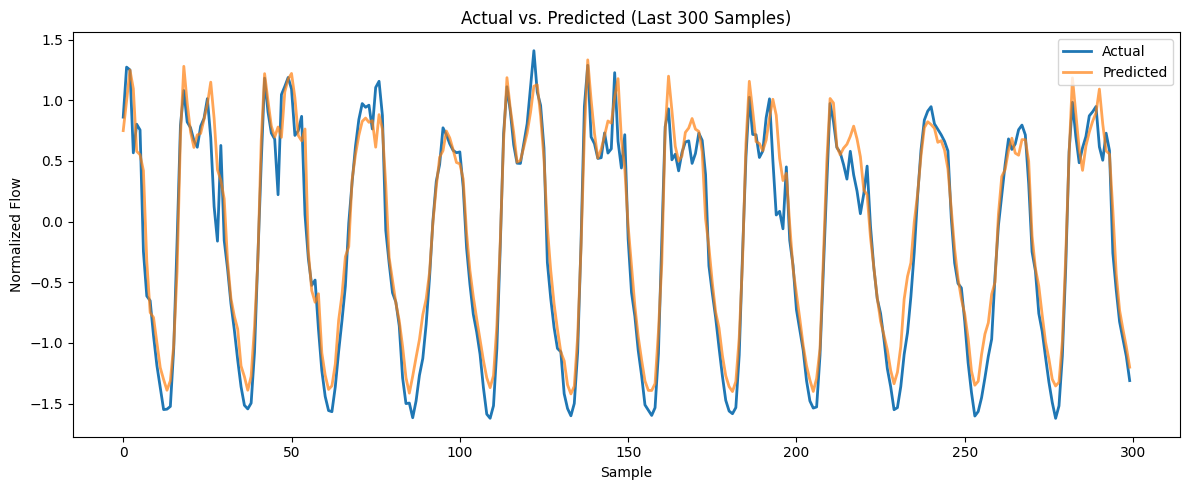

Final Test Metrics:
MAE: 0.17078471183776855
MSE: 0.05211038514971733
R² : 0.9408026933670044


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== Trans → LSTM Model ==========
class Trans_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 trans_heads=4, trans_ff=128,
                 lstm_dim=64, dropout=0.7):
        super().__init__()
        self.pos = nn.Parameter(torch.randn(1, seq_len, in_dim))
        self.trans = nn.MultiheadAttention(in_dim, trans_heads, batch_first=True)
        self.ff = nn.Sequential(nn.LayerNorm(in_dim),
                                nn.Linear(in_dim, trans_ff), nn.ReLU(),
                                nn.Linear(trans_ff, in_dim))
        self.lstm = nn.LSTM(in_dim, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = x + self.pos
        a, _ = self.trans(z, z, z)
        y = self.ff(a + z)
        h, _ = self.lstm(y)
        return self.head(h[:, -1, :])

# ========== Greenshields FD Function (Normalized) ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled

# ========== Custom FD-Informed Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.01, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve Plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
# ======= Model Initialization =======
model = Trans_LSTM(
    in_dim=train_ds.X.shape[2],      # Number of input features (e.g., 1 for flow)
    seq_len=train_ds.X.shape[1],     # Input sequence length (e.g., 24)
    trans_heads=4,                   # Number of attention heads
    trans_ff=32,                    # Feedforward dimension inside transformer
    lstm_dim=16,                     # LSTM hidden units
    dropout=0.7                      # Dropout rate
)

# ======= Model Training =======
model, metrics = train_fd_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4,
    alpha=0.01  # FD loss weighting
)

# ======= Results =======
print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])



In [ ]:
# trans-lstm with out

Epoch 01 | Train MAE: 0.2768 | Val MAE: 0.2901
Epoch 02 | Train MAE: 0.2099 | Val MAE: 0.2609
Epoch 03 | Train MAE: 0.1912 | Val MAE: 0.2370
Epoch 04 | Train MAE: 0.1730 | Val MAE: 0.2152
Epoch 05 | Train MAE: 0.1789 | Val MAE: 0.2340
Epoch 06 | Train MAE: 0.1814 | Val MAE: 0.2198
Epoch 07 | Train MAE: 0.1706 | Val MAE: 0.2201
Epoch 08 | Train MAE: 0.1712 | Val MAE: 0.2152
Epoch 09 | Train MAE: 0.1977 | Val MAE: 0.2350
Epoch 10 | Train MAE: 0.1978 | Val MAE: 0.2232
Epoch 11 | Train MAE: 0.1451 | Val MAE: 0.2008
Epoch 12 | Train MAE: 0.1755 | Val MAE: 0.2108
Epoch 13 | Train MAE: 0.1808 | Val MAE: 0.2218
Epoch 14 | Train MAE: 0.1521 | Val MAE: 0.2035
Epoch 15 | Train MAE: 0.1632 | Val MAE: 0.2029
Epoch 16 | Train MAE: 0.1533 | Val MAE: 0.1959
Epoch 17 | Train MAE: 0.1696 | Val MAE: 0.2121
Epoch 18 | Train MAE: 0.1601 | Val MAE: 0.1990
Epoch 19 | Train MAE: 0.1674 | Val MAE: 0.2100
Epoch 20 | Train MAE: 0.1410 | Val MAE: 0.1865
Epoch 21 | Train MAE: 0.1340 | Val MAE: 0.1819
Epoch 22 | Tr

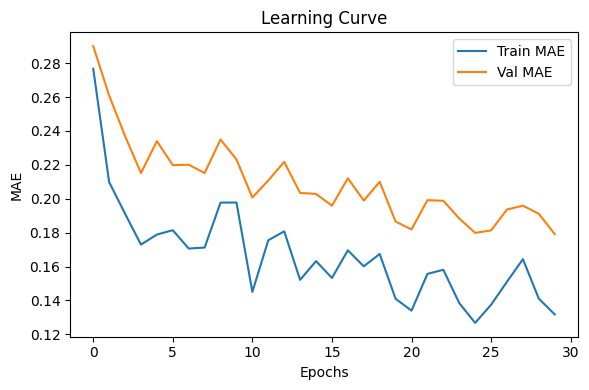


Test MAE: 0.1639
Test MSE: 0.0492
Test R²:  0.9441


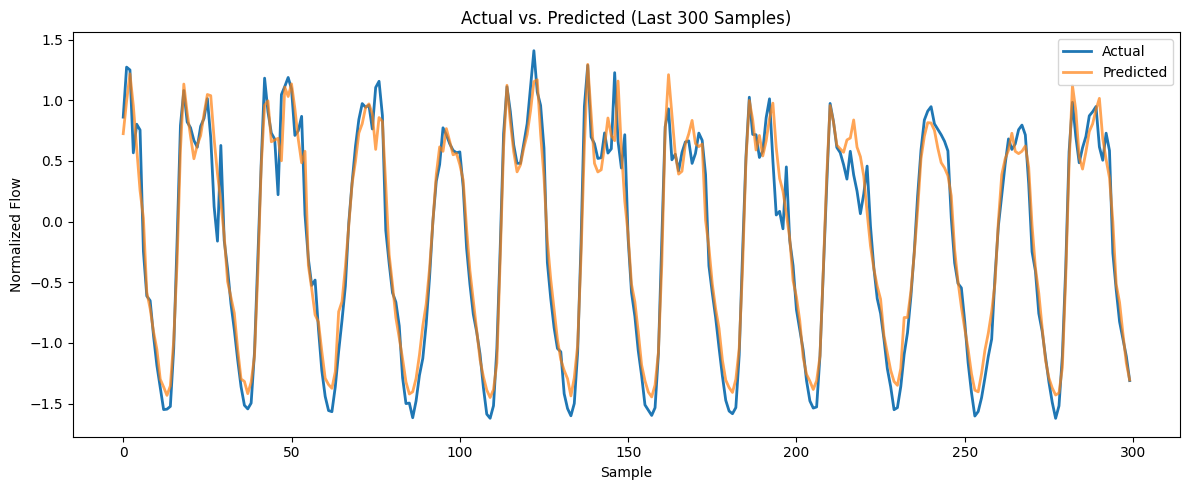

Final Test Metrics:
MAE: 0.1639186590909958
MSE: 0.04922939091920853
R² : 0.9440755248069763


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== Trans → LSTM Model ==========
class Trans_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 trans_heads=4, trans_ff=128,
                 lstm_dim=64, dropout=0.7):
        super().__init__()
        self.pos = nn.Parameter(torch.randn(1, seq_len, in_dim))
        self.trans = nn.MultiheadAttention(in_dim, trans_heads, batch_first=True)
        self.ff = nn.Sequential(nn.LayerNorm(in_dim),
                                nn.Linear(in_dim, trans_ff), nn.ReLU(),
                                nn.Linear(trans_ff, in_dim))
        self.lstm = nn.LSTM(in_dim, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = x + self.pos
        a, _ = self.trans(z, z, z)
        y = self.ff(a + z)
        h, _ = self.lstm(y)
        return self.head(h[:, -1, :])

# ========== Standard MAE Loss ==========
class MAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = MAELoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true = [], []
            v_pred, v_true = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve Plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test Evaluation ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²:  {r2:.4f}")

    # --- Prediction Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs. Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = Trans_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    trans_heads=4,
    trans_ff=32,
    lstm_dim=16,
    dropout=0.7
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


Epoch 01 | Train MAE: 0.2792 | Val MAE: 0.2910
Epoch 02 | Train MAE: 0.2369 | Val MAE: 0.2635
Epoch 03 | Train MAE: 0.1876 | Val MAE: 0.2195
Epoch 04 | Train MAE: 0.1731 | Val MAE: 0.1974
Epoch 05 | Train MAE: 0.1662 | Val MAE: 0.1908
Epoch 06 | Train MAE: 0.1550 | Val MAE: 0.1685
Epoch 07 | Train MAE: 0.1573 | Val MAE: 0.1668
Epoch 08 | Train MAE: 0.1293 | Val MAE: 0.1473
Epoch 09 | Train MAE: 0.1322 | Val MAE: 0.1471
Epoch 10 | Train MAE: 0.1283 | Val MAE: 0.1419
Epoch 11 | Train MAE: 0.1426 | Val MAE: 0.1517
Epoch 12 | Train MAE: 0.1476 | Val MAE: 0.1560
Epoch 13 | Train MAE: 0.1214 | Val MAE: 0.1400
Epoch 14 | Train MAE: 0.1246 | Val MAE: 0.1401
Epoch 15 | Train MAE: 0.1298 | Val MAE: 0.1467
Epoch 16 | Train MAE: 0.1399 | Val MAE: 0.1467
Epoch 17 | Train MAE: 0.1419 | Val MAE: 0.1471
Epoch 18 | Train MAE: 0.1135 | Val MAE: 0.1354
Epoch 19 | Train MAE: 0.1167 | Val MAE: 0.1357
Epoch 20 | Train MAE: 0.1248 | Val MAE: 0.1422
Epoch 21 | Train MAE: 0.1482 | Val MAE: 0.1528
Epoch 22 | Tr

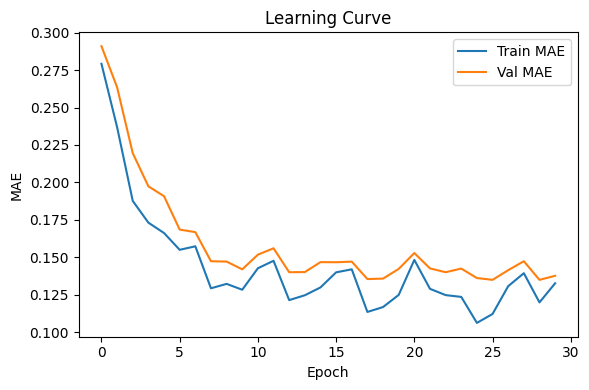


Test MAE: 0.1507
Test MSE: 0.0395
Test R² : 0.9551


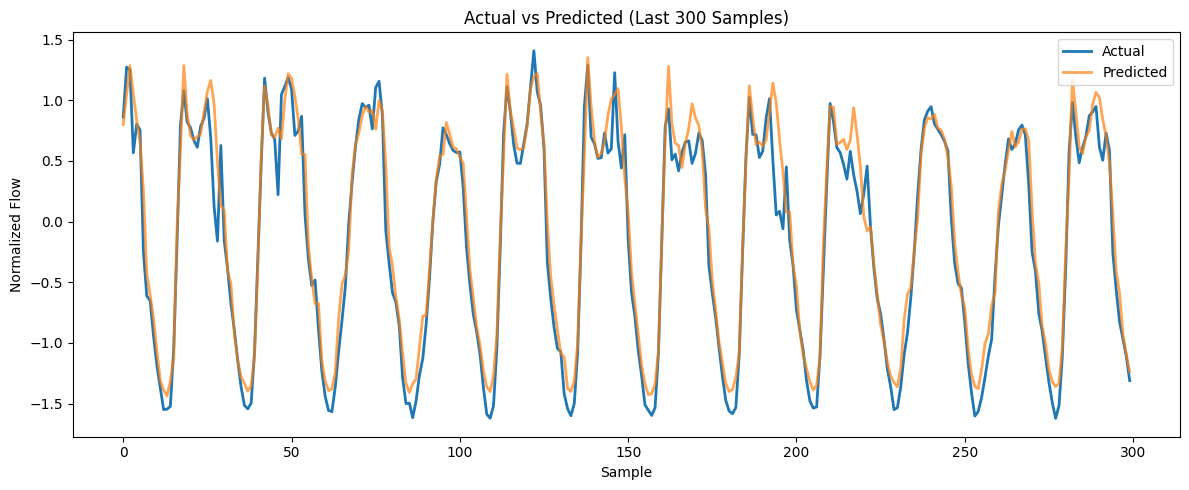

Final Test Metrics:
MAE: 0.15068894624710083
MSE: 0.03950488194823265
R² : 0.9551225304603577


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== TCN→LSTM Model ==========
class TCN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 tcn_filters=(64, 32), tcn_kernel=3, tcn_dilations=(1, 2, 4),
                 lstm_dim=64, dropout=0.3):
        super().__init__()
        layers, ch = [], in_dim
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            layers += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.tcn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Greenshields FD Function ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled

# ========== Custom FD-Informed Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.01, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Final Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Plot Predictions ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = TCN_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    tcn_filters=(32, 16),
    tcn_kernel=4,
    tcn_dilations=(1, 2),
    lstm_dim=16,
    dropout=0.6
)

model, metrics = train_fd_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4,
    alpha=0.01
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


In [ ]:
#tcn-lstm with out

Epoch 01 | Train MAE: 0.2854 | Val MAE: 0.3015
Epoch 02 | Train MAE: 0.2119 | Val MAE: 0.2434
Epoch 03 | Train MAE: 0.1859 | Val MAE: 0.2082
Epoch 04 | Train MAE: 0.1582 | Val MAE: 0.1836
Epoch 05 | Train MAE: 0.1543 | Val MAE: 0.1776
Epoch 06 | Train MAE: 0.1505 | Val MAE: 0.1733
Epoch 07 | Train MAE: 0.1571 | Val MAE: 0.1791
Epoch 08 | Train MAE: 0.1488 | Val MAE: 0.1631
Epoch 09 | Train MAE: 0.1587 | Val MAE: 0.1716
Epoch 10 | Train MAE: 0.1365 | Val MAE: 0.1579
Epoch 11 | Train MAE: 0.1555 | Val MAE: 0.1649
Epoch 12 | Train MAE: 0.1295 | Val MAE: 0.1522
Epoch 13 | Train MAE: 0.1223 | Val MAE: 0.1544
Epoch 14 | Train MAE: 0.1239 | Val MAE: 0.1479
Epoch 15 | Train MAE: 0.1398 | Val MAE: 0.1562
Epoch 16 | Train MAE: 0.1400 | Val MAE: 0.1571
Epoch 17 | Train MAE: 0.1261 | Val MAE: 0.1500
Epoch 18 | Train MAE: 0.1368 | Val MAE: 0.1565
Epoch 19 | Train MAE: 0.1367 | Val MAE: 0.1550
Epoch 20 | Train MAE: 0.1395 | Val MAE: 0.1576
Epoch 21 | Train MAE: 0.1131 | Val MAE: 0.1451
Epoch 22 | Tr

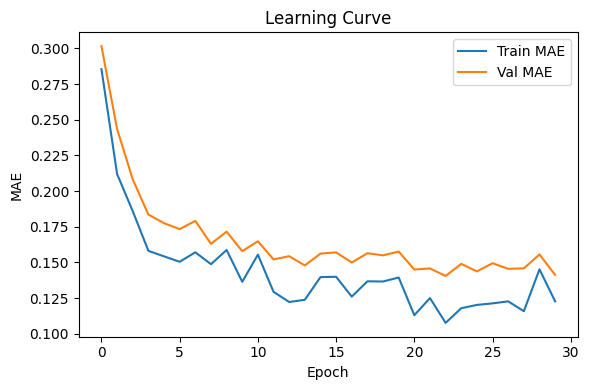


Test MAE: 0.1452
Test MSE: 0.0370
Test R² : 0.9580


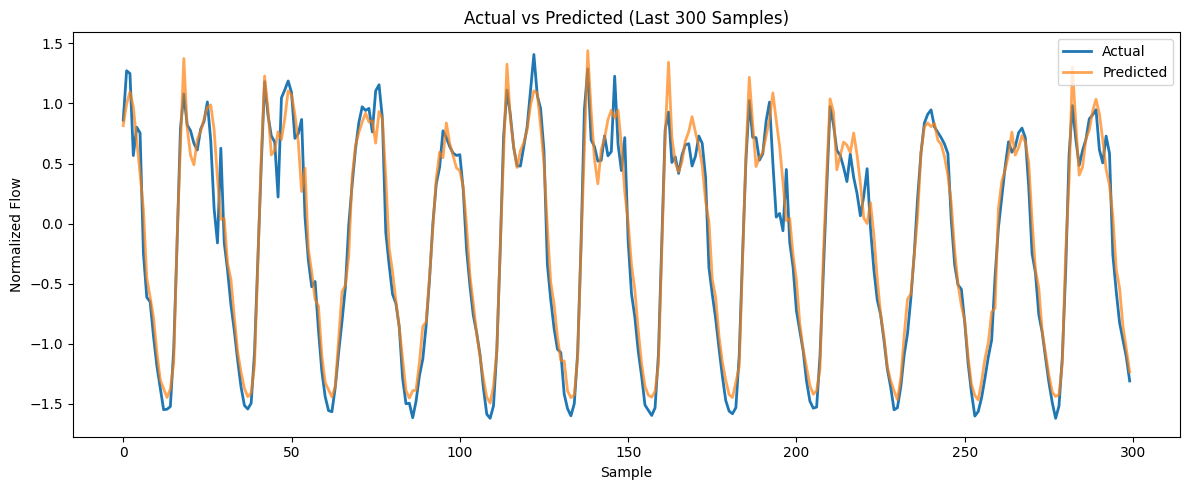

Final Test Metrics:
MAE: 0.14519867300987244
MSE: 0.036962538957595825
R² : 0.9580106139183044


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== TCN → LSTM Model ==========
class TCN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 tcn_filters=(64, 32), tcn_kernel=3, tcn_dilations=(1, 2, 4),
                 lstm_dim=64, dropout=0.3):
        super().__init__()
        layers, ch = [], in_dim
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            layers += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*layers)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.tcn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Standard MAE Loss ==========
class MAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = MAELoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Final Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Plot Predictions ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = TCN_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    tcn_filters=(32, 16),
    tcn_kernel=4,
    tcn_dilations=(1, 2),
    lstm_dim=16,
    dropout=0.6
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


Epoch 01 | Train MAE: 0.2162 | Val MAE: 0.2531
Epoch 02 | Train MAE: 0.1943 | Val MAE: 0.2231
Epoch 03 | Train MAE: 0.1844 | Val MAE: 0.2294
Epoch 04 | Train MAE: 0.1781 | Val MAE: 0.2068
Epoch 05 | Train MAE: 0.1666 | Val MAE: 0.1967
Epoch 06 | Train MAE: 0.2075 | Val MAE: 0.2159
Epoch 07 | Train MAE: 0.1695 | Val MAE: 0.1936
Epoch 08 | Train MAE: 0.1794 | Val MAE: 0.1967
Epoch 09 | Train MAE: 0.1667 | Val MAE: 0.1915
Epoch 10 | Train MAE: 0.1737 | Val MAE: 0.1896
Epoch 11 | Train MAE: 0.1660 | Val MAE: 0.1797
Epoch 12 | Train MAE: 0.1683 | Val MAE: 0.1835
Epoch 13 | Train MAE: 0.1506 | Val MAE: 0.1682
Epoch 14 | Train MAE: 0.1565 | Val MAE: 0.1713
Epoch 15 | Train MAE: 0.1531 | Val MAE: 0.1682
Epoch 16 | Train MAE: 0.1724 | Val MAE: 0.1804
Epoch 17 | Train MAE: 0.1641 | Val MAE: 0.1810
Epoch 18 | Train MAE: 0.1749 | Val MAE: 0.1766
Epoch 19 | Train MAE: 0.1457 | Val MAE: 0.1597
Epoch 20 | Train MAE: 0.1477 | Val MAE: 0.1700
Epoch 21 | Train MAE: 0.1593 | Val MAE: 0.1734
Epoch 22 | Tr

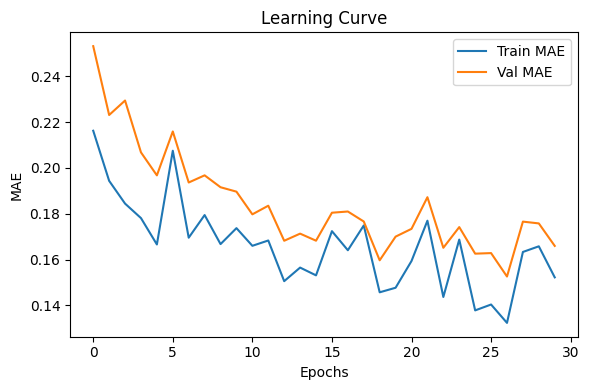


Test MAE: 0.1660
Test MSE: 0.0456
Test R² : 0.9482


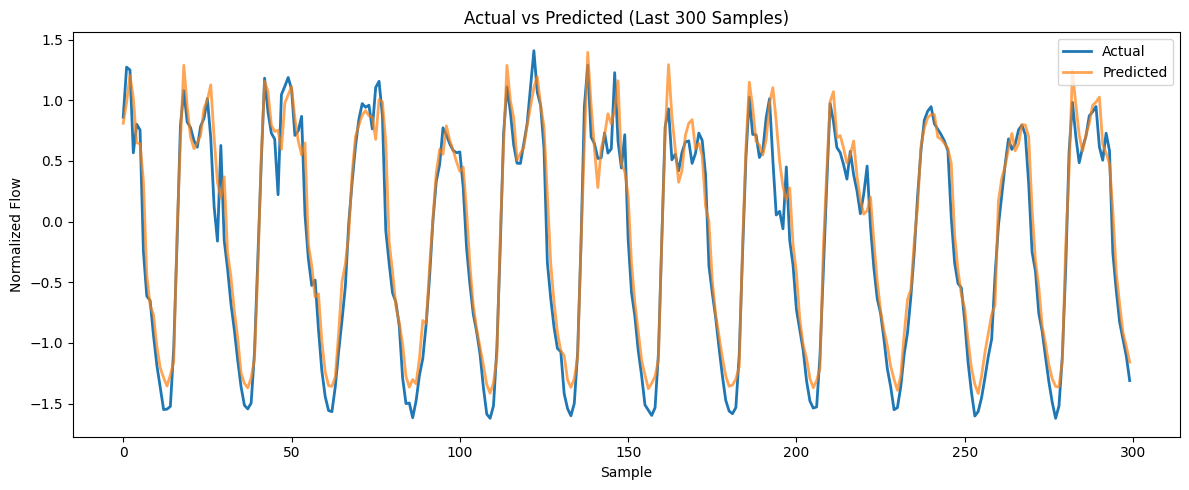

Final Test Metrics:
MAE: 0.1660376936197281
MSE: 0.045600585639476776
R² : 0.9481978416442871


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN→LSTM Model ==========
class CNN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16), kernel_size=3,
                 lstm_dim=64, dropout=0.3):
        super().__init__()
        layers, ch = [], in_dim
        for c in cnn_ch:
            layers += [nn.Conv1d(ch, c, kernel_size=kernel_size, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*layers)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Greenshields FD Function ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled

# ========== FD-Informed Custom Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.01, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Final Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Prediction Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = CNN_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    cnn_ch=(16, 128),
    kernel_size=3,
    lstm_dim=16,
    dropout=0.7
)

model, metrics = train_fd_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4,
    alpha=0.01
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


In [ ]:
#cnn-lstm with out

Epoch 01 | Train MAE: 0.2341 | Val MAE: 0.2329
Epoch 02 | Train MAE: 0.1960 | Val MAE: 0.2045
Epoch 03 | Train MAE: 0.1761 | Val MAE: 0.1907
Epoch 04 | Train MAE: 0.1645 | Val MAE: 0.1835
Epoch 05 | Train MAE: 0.1758 | Val MAE: 0.1855
Epoch 06 | Train MAE: 0.1697 | Val MAE: 0.1779
Epoch 07 | Train MAE: 0.1721 | Val MAE: 0.1759
Epoch 08 | Train MAE: 0.1643 | Val MAE: 0.1684
Epoch 09 | Train MAE: 0.1852 | Val MAE: 0.1821
Epoch 10 | Train MAE: 0.1901 | Val MAE: 0.1826
Epoch 11 | Train MAE: 0.1737 | Val MAE: 0.1699
Epoch 12 | Train MAE: 0.1463 | Val MAE: 0.1595
Epoch 13 | Train MAE: 0.1674 | Val MAE: 0.1724
Epoch 14 | Train MAE: 0.1592 | Val MAE: 0.1660
Epoch 15 | Train MAE: 0.1697 | Val MAE: 0.1692
Epoch 16 | Train MAE: 0.1593 | Val MAE: 0.1676
Epoch 17 | Train MAE: 0.1968 | Val MAE: 0.1951
Epoch 18 | Train MAE: 0.1787 | Val MAE: 0.1799
Epoch 19 | Train MAE: 0.1670 | Val MAE: 0.1684
Epoch 20 | Train MAE: 0.1583 | Val MAE: 0.1619
Epoch 21 | Train MAE: 0.1569 | Val MAE: 0.1698
Epoch 22 | Tr

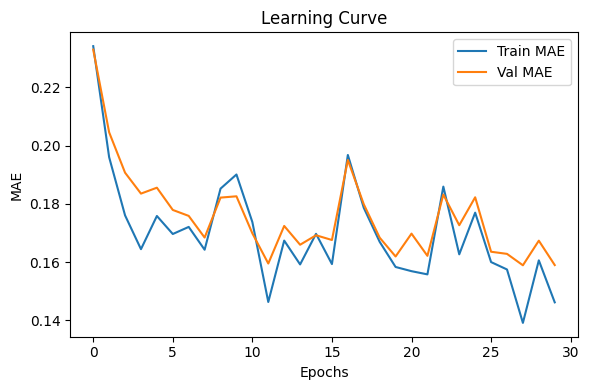


Test MAE: 0.1674
Test MSE: 0.0451
Test R² : 0.9488


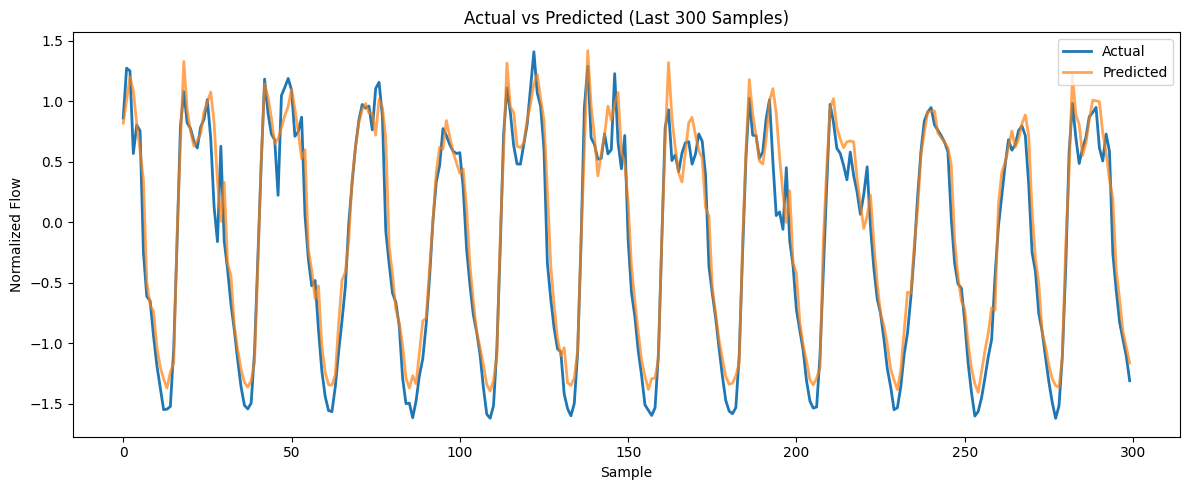

Final Test Metrics:
MAE: 0.16736871004104614
MSE: 0.04505259543657303
R² : 0.9488203525543213


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN → LSTM Model ==========
class CNN_LSTM(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16), kernel_size=3,
                 lstm_dim=64, dropout=0.3):
        super().__init__()
        layers, ch = [], in_dim
        for c in cnn_ch:
            layers += [nn.Conv1d(ch, c, kernel_size=kernel_size, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*layers)
        self.lstm = nn.LSTM(ch, lstm_dim, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(lstm_dim, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)
        h, _ = self.lstm(z)
        return self.head(h[:, -1, :])

# ========== Standard MAE Loss ==========
class MAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = MAELoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Final Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Prediction Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = CNN_LSTM(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    cnn_ch=(16, 128),
    kernel_size=3,
    lstm_dim=16,
    dropout=0.7
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


Epoch 01 | Train MAE: 0.2730 | Val MAE: 0.2795
Epoch 02 | Train MAE: 0.2130 | Val MAE: 0.2471
Epoch 03 | Train MAE: 0.2044 | Val MAE: 0.1957
Epoch 04 | Train MAE: 0.2185 | Val MAE: 0.1946
Epoch 05 | Train MAE: 0.1728 | Val MAE: 0.1683
Epoch 06 | Train MAE: 0.1868 | Val MAE: 0.1739
Epoch 07 | Train MAE: 0.1821 | Val MAE: 0.1687
Epoch 08 | Train MAE: 0.1601 | Val MAE: 0.1549
Epoch 09 | Train MAE: 0.1456 | Val MAE: 0.1482
Epoch 10 | Train MAE: 0.1838 | Val MAE: 0.1732
Epoch 11 | Train MAE: 0.1695 | Val MAE: 0.1818
Epoch 12 | Train MAE: 0.1655 | Val MAE: 0.1508
Epoch 13 | Train MAE: 0.1657 | Val MAE: 0.1670
Epoch 14 | Train MAE: 0.2077 | Val MAE: 0.1850
Epoch 15 | Train MAE: 0.1649 | Val MAE: 0.1550
Epoch 16 | Train MAE: 0.1949 | Val MAE: 0.1701
Epoch 17 | Train MAE: 0.1389 | Val MAE: 0.1407
Epoch 18 | Train MAE: 0.1219 | Val MAE: 0.1365
Epoch 19 | Train MAE: 0.1631 | Val MAE: 0.1588
Epoch 20 | Train MAE: 0.1773 | Val MAE: 0.1652
Epoch 21 | Train MAE: 0.1528 | Val MAE: 0.1552
Epoch 22 | Tr

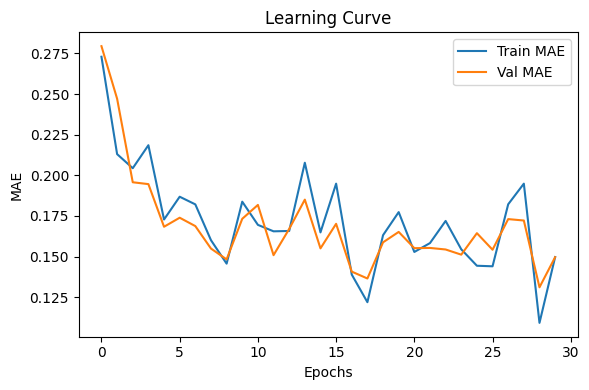


Test MAE: 0.1770
Test MSE: 0.0487
Test R² : 0.9447


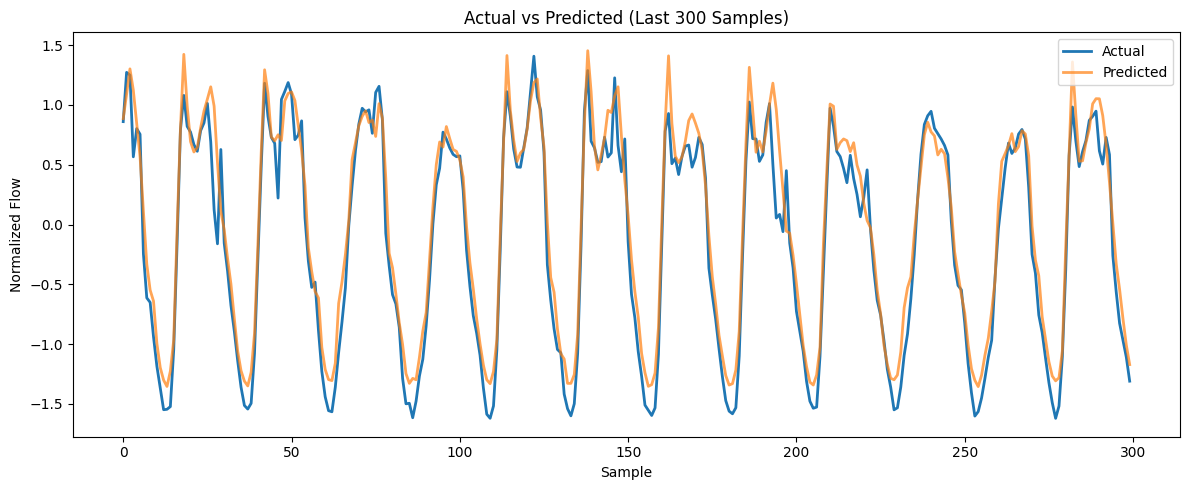

Final Test Metrics:
MAE: 0.17702282965183258
MSE: 0.04872146621346474
R² : 0.9446524977684021


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN→Transformer→TCN Model ==========
class CNN_Trans_TCN(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16),
                 trans_heads=2, trans_ff=128,
                 tcn_filters=(32, 16), tcn_kernel=3, tcn_dilations=(1, 2, 4),
                 dropout=0.5):
        super().__init__()
        # CNN block
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch, c, kernel_size=3, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)

        # Transformer block
        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)
        self.ff = nn.Sequential(nn.LayerNorm(ch),
                                nn.Linear(ch, trans_ff), nn.ReLU(),
                                nn.Linear(trans_ff, ch))

        # TCN block
        tcn_blocks = []
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            tcn_blocks += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)

        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(ch, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        z = z + self.pos
        a, _ = self.trans(z, z, z)
        z = self.ff(a + z).permute(0, 2, 1)
        z = self.tcn(z)[..., :x.size(1)].permute(0, 2, 1)
        return self.head(z[:, -1, :])

# ========== Greenshields FD Function ==========
def fd_flow_greenshields(x, vf=81.27, kj=335.9,
                         occ_mean=5.86, occ_std=4.98,
                         flow_mean=3664.52, flow_std=1967.74):
    """
    x : scaled input tensor of shape (batch, seq_len, features)
    vf, kj : physical Greenshields parameters
    occ_mean, occ_std : mean and std of 'Occupancy (%)' (for inverse scaling)
    flow_mean, flow_std : mean and std of 'Flow (Veh/Hour)' (for output scaling)
    """
    # Step 1: Get last timestep occupancy (still in scaled space)
    occ_scaled = x[:, -1, 0]

    # Step 2: Convert scaled occupancy back to real scale
    occ_real = occ_scaled * occ_std + occ_mean

    # Step 3: Compute density (veh/mi)
    density = occ_real * kj

    # Step 4: Compute real flow using Greenshields model
    flow_real = vf * density * (1 - density / kj)

    # Step 5: Scale flow to match the normalized data
    flow_scaled = (flow_real - flow_mean) / flow_std

    return flow_scaled

# ========== FD-Informed Loss ==========
class FDLoss(nn.Module):
    def __init__(self, alpha=0.01, vf=81.27, kj=335.9):
        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.vf = vf
        self.kj = kj

    def forward(self, y_pred, y_true, x_input):
        loss_pred = self.mae(y_pred.squeeze(), y_true.squeeze())
        fd_pred = fd_flow_greenshields(x_input, vf=self.vf, kj=self.kj)
        loss_fd = self.mae(y_pred.squeeze(), fd_pred)
        return loss_pred + self.alpha * loss_fd

# ========== Train + Evaluate + Plot ==========
def train_fd_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4, alpha=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = FDLoss(alpha=alpha)

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb, xb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = CNN_Trans_TCN(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    cnn_ch=(32, 16),
    trans_heads=2,
    trans_ff=128,
    tcn_filters=(32, 16),
    tcn_kernel=3,
    tcn_dilations=(1, 2, 4),
    dropout=0.5
)

model, metrics = train_fd_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4,
    alpha=0.01
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


In [ ]:
#cnn-trans-tcn with out

Epoch 01 | Train MAE: 0.2247 | Val MAE: 0.2539
Epoch 02 | Train MAE: 0.1816 | Val MAE: 0.1879
Epoch 03 | Train MAE: 0.1895 | Val MAE: 0.1857
Epoch 04 | Train MAE: 0.2388 | Val MAE: 0.2157
Epoch 05 | Train MAE: 0.2120 | Val MAE: 0.1878
Epoch 06 | Train MAE: 0.2343 | Val MAE: 0.2039
Epoch 07 | Train MAE: 0.2278 | Val MAE: 0.2035
Epoch 08 | Train MAE: 0.2219 | Val MAE: 0.1958
Epoch 09 | Train MAE: 0.1658 | Val MAE: 0.1564
Epoch 10 | Train MAE: 0.1732 | Val MAE: 0.1651
Epoch 11 | Train MAE: 0.1561 | Val MAE: 0.1588
Epoch 12 | Train MAE: 0.1866 | Val MAE: 0.1717
Epoch 13 | Train MAE: 0.1572 | Val MAE: 0.1489
Epoch 14 | Train MAE: 0.1840 | Val MAE: 0.1736
Epoch 15 | Train MAE: 0.2153 | Val MAE: 0.1878
Epoch 16 | Train MAE: 0.1665 | Val MAE: 0.1638
Epoch 17 | Train MAE: 0.1950 | Val MAE: 0.1775
Epoch 18 | Train MAE: 0.1779 | Val MAE: 0.1699
Epoch 19 | Train MAE: 0.1574 | Val MAE: 0.1608
Epoch 20 | Train MAE: 0.2117 | Val MAE: 0.1922
Epoch 21 | Train MAE: 0.2035 | Val MAE: 0.1833
Epoch 22 | Tr

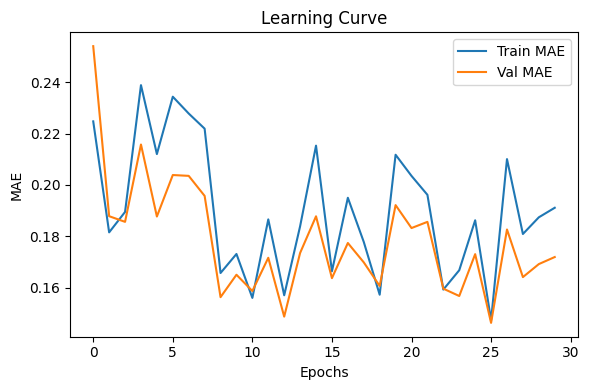


Test MAE: 0.1858
Test MSE: 0.0524
Test R² : 0.9404


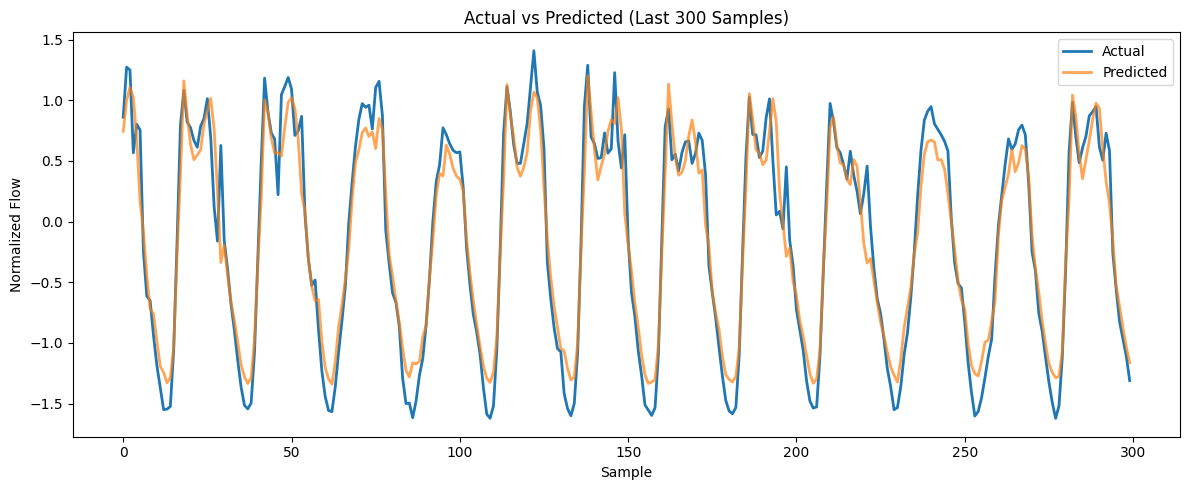

Final Test Metrics:
MAE: 0.18584929406642914
MSE: 0.05243954807519913
R² : 0.9404287934303284


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========== CNN→Transformer→TCN Model ==========
class CNN_Trans_TCN(nn.Module):
    def __init__(self, in_dim, seq_len,
                 cnn_ch=(32, 16),
                 trans_heads=2, trans_ff=128,
                 tcn_filters=(32, 16), tcn_kernel=3, tcn_dilations=(1, 2, 4),
                 dropout=0.5):
        super().__init__()
        convs, ch = [], in_dim
        for c in cnn_ch:
            convs += [nn.Conv1d(ch, c, kernel_size=3, padding=1), nn.ReLU()]
            ch = c
        self.cnn = nn.Sequential(*convs)

        self.pos = nn.Parameter(torch.randn(1, seq_len, ch))
        self.trans = nn.MultiheadAttention(ch, trans_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.LayerNorm(ch),
            nn.Linear(ch, trans_ff), nn.ReLU(),
            nn.Linear(trans_ff, ch)
        )

        tcn_blocks = []
        for f, d in zip(tcn_filters, tcn_dilations):
            pad = (tcn_kernel - 1) * d
            tcn_blocks += [nn.Conv1d(ch, f, tcn_kernel, padding=pad, dilation=d), nn.ReLU()]
            ch = f
        self.tcn = nn.Sequential(*tcn_blocks)

        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(ch, 1))

    def forward(self, x):
        z = self.cnn(x.permute(0, 2, 1))[..., :x.size(1)].permute(0, 2, 1)
        z = z + self.pos
        a, _ = self.trans(z, z, z)
        z = self.ff(a + z).permute(0, 2, 1)
        z = self.tcn(z)[..., :x.size(1)].permute(0, 2, 1)
        return self.head(z[:, -1, :])

# ========== Basic L1 Loss ==========
class BasicLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        return self.mae(y_pred.squeeze(), y_true.squeeze())

# ========== Train + Evaluate + Plot ==========
def train_model(model, train_loader, val_loader, test_loader, epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = BasicLoss()

    train_mae, val_mae = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            t_pred, t_true, v_pred, v_true = [], [], [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                t_pred.append(model(xb).cpu().numpy())
                t_true.append(yb.numpy())
            for xb, yb in val_loader:
                xb = xb.to(device)
                v_pred.append(model(xb).cpu().numpy())
                v_true.append(yb.numpy())

        t_mae = mean_absolute_error(np.vstack(t_true), np.vstack(t_pred))
        v_mae = mean_absolute_error(np.vstack(v_true), np.vstack(v_pred))
        train_mae.append(t_mae)
        val_mae.append(v_mae)
        print(f"Epoch {epoch+1:02d} | Train MAE: {t_mae:.4f} | Val MAE: {v_mae:.4f}")

    # --- Learning curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Val MAE")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Test ---
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)

    print(f"\nTest MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # --- Prediction plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(trues[-300:], label="Actual", linewidth=2)
    plt.plot(preds[-300:], label="Predicted", linewidth=2, alpha=0.7)
    plt.xlabel("Sample")
    plt.ylabel("Normalized Flow")
    plt.title("Actual vs Predicted (Last 300 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, {'mae': mae, 'mse': mse, 'r2': r2}

# ========== Usage ==========
model = CNN_Trans_TCN(
    in_dim=train_ds.X.shape[2],
    seq_len=train_ds.X.shape[1],
    cnn_ch=(32, 16),
    trans_heads=2,
    trans_ff=128,
    tcn_filters=(32, 16),
    tcn_kernel=3,
    tcn_dilations=(1, 2, 4),
    dropout=0.5
)

model, metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=5e-4
)

print("Final Test Metrics:")
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("R² :", metrics['r2'])


In [ ]:
import pandas as pd

# Data from the handwritten table
data_cnntcnlstm_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.137, 0.146, 0.149, 0.144, 0.140, 0.1348, 0.1409, 0.146, 0.150, 0.146],
    "MSE": [0.0337, 0.039, 0.039, 0.0358, 0.0374, 0.0334, 0.0355, 0.0413, 0.0397, 0.0404],
    "R2":   [0.9616, 0.9557, 0.9559, 0.9593, 0.9575, 0.9621, 0.9597, 0.9531, 0.9549, 0.9541]
}

data_cnntcnlstm_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.143, 0.1494, 0.149, 0.150, 0.1493, 0.159, 0.153, 0.152, 0.1606, 0.148],
    "MSE": [0.0386, 0.0397, 0.0393, 0.0410, 0.0401, 0.0436, 0.0417, 0.0416, 0.0451, 0.0380],
    "R2":   [0.9562, 0.9549, 0.9554, 0.9534, 0.9545, 0.95, 0.9526, 0.9526, 0.9488, 0.9568]
}



data_tcntranslstm_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.153, 0.151, 0.142, 0.184, 0.1651, 0.1446, 0.1634, 0.149, 0.1677, 0.176],
    "MSE": [0.0378, 0.0379, 0.0332, 0.0522, 0.0427, 0.0366, 0.0429, 0.0377, 0.0435, 0.0498],
    "R2":   [0.957, 0.9569, 0.9623, 0.94, 0.9515, 0.9584, 0.9513, 0.9579, 0.9506, 0.9434]
}



data_tcntranslstm_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.178, 0.1513, 0.1583, 0.144, 0.1558, 0.1377, 0.174, 0.2033, 0.179, 0.1555],
    "MSE": [0.048, 0.0367, 0.0391, 0.035, 0.0383, 0.0333, 0.0459, 0.0613, 0.0477, 0.0384],
    "R2":   [0.9454, 0.9583, 0.9556, 0.9603, 0.9565, 0.9622, 0.948, 0.9304, 0.9458, 0.9564]
}


data_translstm_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.168, 0.1646, 0.1692, 0.1761, 0.1805, 0.1827, 0.1637, 0.1555, 0.196, 0.1708],
    "MSE": [0.0479, 0.0473, 0.0460, 0.0522, 0.0602, 0.0555, 0.0423, 0.046, 0.0626, 0.0521],
    "R2":   [0.95456, 0.9463, 0.9478, 0.9408, 0.9316, 0.937, 0.952, 0.9477, 0.929, 0.9408]
}



data_translstm_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.1703, 0.1631, 0.166, 0.192, 0.152, 0.2025, 0.152, 0.1781, 0.193, 0.164],
    "MSE": [0.0629, 0.0463, 0.0478, 0.056, 0.0452, 0.0631, 0.0454, 0.0548, 0.068, 0.051],
    "R2":   [0.9285, 0.9474, 0.9457, 0.9365, 0.9486, 0.9283, 0.9485, 0.9378, 0.9227, 0.9441]
}


data_tcnlstm_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.1613, 0.1288, 0.1473, 0.152, 0.1426, 0.144, 0.1527, 0.150, 0.1458, 0.1507],
    "MSE": [0.0444, 0.0328, 0.0398, 0.0421, 0.0381, 0.0372, 0.0417, 0.0407, 0.0392, 0.0395],
    "R2":   [0.9496, 0.9627, 0.9548, 0.9522, 0.9568, 0.9577, 0.9526, 0.9538, 0.9554, 0.9551]
}



data_tcnlstm_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.150, 0.144, 0.155, 0.162, 0.149, 0.147, 0.144, 0.164, 0.147, 0.146],
    "MSE": [0.0389, 0.0378, 0.0413, 0.0441, 0.0401, 0.0394, 0.0387, 0.0449, 0.0372, 0.0370],
    "R2":   [0.9558, 0.9571, 0.9531, 0.950, 0.9545, 0.9553, 0.9561, 0.9489, 0.9577, 0.9580]
}




data_cnnlstm_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.185, 0.156, 0.190, 0.173, 0.1553, 0.1716, 0.1629, 0.159, 0.1719, 0.166],
    "MSE": [0.0584, 0.0415, 0.0611, 0.0480, 0.0414, 0.048, 0.043, 0.0432, 0.0524, 0.0456],
    "R2":   [0.9337, 0.9529, 0.9305, 0.9455, 0.953, 0.9455, 0.9511, 0.9509, 0.9404, 0.9482]
}



data_cnnlstm_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.1585, 0.171, 0.192, 0.170, 0.1771, 0.183, 0.181, 0.172, 0.179, 0.168],
    "MSE": [0.0434, 0.0497, 0.0618, 0.0493, 0.0523, 0.056, 0.0557, 0.0472, 0.0544, 0.0451],
    "R2":   [0.9507, 0.9435, 0.9299, 0.9439, 0.9405, 0.9364, 0.9368, 0.9464, 0.9382, 0.9488]
}



data_cnntranstcn_with = {
    "Run": list(range(1, 11)),
    "MAE": [0.179, 0.1397, 0.1712, 0.187, 0.165, 0.160, 0.1535, 0.191, 0.184, 0.177],
    "MSE": [0.0524, 0.0345, 0.0448, 0.0557, 0.0419, 0.0411, 0.0384, 0.056, 0.0495, 0.0487],
    "R2":   [0.9405, 0.9608, 0.9491, 0.9368, 0.9524, 0.9533, 0.9563, 0.9364, 0.9438, 0.9447]
}



data_cnntranstcn_without = {
    "Run": list(range(1, 11)),
    "MAE": [0.1833, 0.2151, 0.1876, 0.154, 0.1813, 0.1852, 0.1664, 0.140, 0.1885, 0.1858],
    "MSE": [0.0533, 0.0714, 0.0528, 0.0372, 0.0505, 0.0522, 0.0432, 0.0344, 0.0531, 0.0524],
    "R2":   [0.9394, 0.9189, 0.940, 0.9577, 0.9426, 0.9407, 0.9509, 0.9610, 0.9397, 0.9404]
}
# Create DataFrame
#df = pd.DataFrame(data)

In [ ]:
# Step 2: Convert to DataFrames and add Model labels
df_with_cnntcnlstm = pd.DataFrame(data_cnntcnlstm_with).assign(Model="CNN-TCN-LSTM")
df_with_tcntranslstm = pd.DataFrame(data_tcntranslstm_with).assign(Model="TCN-Trans-LSTM")
df_with_translstm = pd.DataFrame(data_translstm_with).assign(Model="Trans-LSTM")
df_with_tcnlstm = pd.DataFrame(data_tcnlstm_with).assign(Model="TCN-LSTM")
df_with_cnnlstm = pd.DataFrame(data_cnnlstm_with).assign(Model="CNN-LSTM")
df_with_cnntranstcn = pd.DataFrame(data_cnntranstcn_with).assign(Model="CNN-Trans-TCN")
# Step 3: Concatenate all data
merged_df = pd.concat([df_with_cnntcnlstm, df_with_tcntranslstm, df_with_translstm, df_with_tcnlstm,df_with_cnnlstm, df_with_cnntranstcn ], ignore_index=True)

# Step 4: Pivot to one-row-per-run format
pivot_df = merged_df.pivot(index="Run", columns="Model", values=["MAE", "MSE", "R2"])

# Step 5: Flatten the MultiIndex column names
pivot_df.columns = [f"{metric}_{model}" for metric, model in pivot_df.columns]
pivot_df = pivot_df.reset_index()

# Final result is stored in pivot_df

In [ ]:
pivot_df

Run  MAE_CNN-LSTM  MAE_CNN-TCN-LSTM  MAE_CNN-Trans-TCN  MAE_TCN-LSTM  \
0    1        0.1850            0.1370             0.1790        0.1613   
1    2        0.1560            0.1460             0.1397        0.1288   
2    3        0.1900            0.1490             0.1712        0.1473   
3    4        0.1730            0.1440             0.1870        0.1520   
4    5        0.1553            0.1400             0.1650        0.1426   
5    6        0.1716            0.1348             0.1600        0.1440   
6    7        0.1629            0.1409             0.1535        0.1527   
7    8        0.1590            0.1460             0.1910        0.1500   
8    9        0.1719            0.1500             0.1840        0.1458   
9   10        0.1660            0.1460             0.1770        0.1507   

   MAE_TCN-Trans-LSTM  MAE_Trans-LSTM  MSE_CNN-LSTM  MSE_CNN-TCN-LSTM  \
0              0.1530          0.1680        0.0584            0.0337   
1              0.1510          0.1646        0.0415            0.0390   
2              0.1420          0.1692        0.0611            0.0390   
3              0.1840          0.1761        0.0480            0.0358   
4              0.1651          0.1805        0.0414            0.0374   
5              0.1446          0.1827        0.0480            0.0334   
6              0.1634          0.1637        0.0430            0.0355   
7              0.1490          0.1555        0.0432            0.0413   
8              0.1677          0.1960        0.0524            0.0397   
9              0.1760          0.1708        0.0456            0.0404   

   MSE_CNN-Trans-TCN  MSE_TCN-LSTM  MSE_TCN-Trans-LSTM  MSE_Trans-LSTM  \
0             0.0524        0.0444              0.0378          0.0479   
1             0.0345        0.0328              0.0379          0.0473   
2             0.0448        0.0398              0.0332          0.0460   
3             0.0557        0.0421              0.0522          0.0522   
4             0.0419        0.0381              0.0427          0.0602   
5             0.0411        0.0372              0.0366          0.0555   
6             0.0384        0.0417              0.0429          0.0423   
7             0.0560        0.0407              0.0377          0.0460   
8             0.0495        0.0392              0.0435          0.0626   
9             0.0487        0.0395              0.0498          0.0521   

   R2_CNN-LSTM  R2_CNN-TCN-LSTM  R2_CNN-Trans-TCN  R2_TCN-LSTM  \
0       0.9337           0.9616            0.9405       0.9496   
1       0.9529           0.9557            0.9608       0.9627   
2       0.9305           0.9559            0.9491       0.9548   
3       0.9455           0.9593            0.9368       0.9522   
4       0.9530           0.9575            0.9524       0.9568   
5       0.9455           0.9621            0.9533       0.9577   
6       0.9511           0.9597            0.9563       0.9526   
7       0.9509           0.9531            0.9364       0.9538   
8       0.9404           0.9549            0.9438       0.9554   
9       0.9482           0.9541            0.9447       0.9551   

   R2_TCN-Trans-LSTM  R2_Trans-LSTM  
0             0.9570        0.95456  
1             0.9569        0.94630  
2             0.9623        0.94780  
3             0.9400        0.94080  
4             0.9515        0.93160  
5             0.9584        0.93700  
6             0.9513        0.95200  
7             0.9579        0.94770  
8             0.9506        0.92900  
9             0.9434        0.94080

In [ ]:
# Step 2: Convert to DataFrames and add Model labels
df_without_cnntcnlstm = pd.DataFrame(data_cnntcnlstm_without).assign(Model="CNN-TCN-LSTM")
df_without_tcntranslstm = pd.DataFrame(data_tcntranslstm_without).assign(Model="TCN-Trans-LSTM")
df_without_translstm = pd.DataFrame(data_translstm_without).assign(Model="Trans-LSTM")
df_without_tcnlstm = pd.DataFrame(data_tcnlstm_without).assign(Model="TCN-LSTM")
df_without_cnnlstm = pd.DataFrame(data_cnnlstm_without).assign(Model="CNN-LSTM")
df_without_cnntranstcn = pd.DataFrame(data_cnntranstcn_without).assign(Model="CNN-Trans-TCN")
# Step 3: Concatenate all data
merged_df2 = pd.concat([df_without_cnntcnlstm, df_without_tcntranslstm, df_without_translstm, df_without_tcnlstm,df_without_cnnlstm, df_without_cnntranstcn ], ignore_index=True)

# Step 4: Pivot to one-row-per-run format
pivot_df2 = merged_df2.pivot(index="Run", columns="Model", values=["MAE", "MSE", "R2"])

# Step 5: Flatten the MultiIndex column names
pivot_df2.columns = [f"{metric}_{model}" for metric, model in pivot_df2.columns]
pivot_df2 = pivot_df2.reset_index()

# Final result is stored in pivot_df

In [ ]:

# Step 6: Compute the mean of each column (excluding 'Run')
average_row = pivot_df2.drop(columns="Run").mean().to_frame().T
average_row.insert(0, "Run", "Average")  # Add a label for the index column

# Step 7: Append the average row to the original pivot_df
pivot_df_with_avg = pd.concat([pivot_df2, average_row], ignore_index=True)

In [ ]:
pivot_df_with_avg

Run  MAE_CNN-LSTM  MAE_CNN-TCN-LSTM  MAE_CNN-Trans-TCN  MAE_TCN-LSTM  \
0         1       0.15850           0.14300            0.18330        0.1500   
1         2       0.17100           0.14940            0.21510        0.1440   
2         3       0.19200           0.14900            0.18760        0.1550   
3         4       0.17000           0.15000            0.15400        0.1620   
4         5       0.17710           0.14930            0.18130        0.1490   
5         6       0.18300           0.15900            0.18520        0.1470   
6         7       0.18100           0.15300            0.16640        0.1440   
7         8       0.17200           0.15200            0.14000        0.1640   
8         9       0.17900           0.16060            0.18850        0.1470   
9        10       0.16800           0.14800            0.18580        0.1460   
10  Average       0.17516           0.15133            0.17872        0.1508   

    MAE_TCN-Trans-LSTM  MAE_Trans-LSTM  MSE_CNN-LSTM  MSE_CNN-TCN-LSTM  \
0              0.17800          0.1703       0.04340           0.03860   
1              0.15130          0.1631       0.04970           0.03970   
2              0.15830          0.1660       0.06180           0.03930   
3              0.14400          0.1920       0.04930           0.04100   
4              0.15580          0.1520       0.05230           0.04010   
5              0.13770          0.2025       0.05600           0.04360   
6              0.17400          0.1520       0.05570           0.04170   
7              0.20330          0.1781       0.04720           0.04160   
8              0.17900          0.1930       0.05440           0.04510   
9              0.15550          0.1640       0.04510           0.03800   
10             0.16369          0.1733       0.05149           0.04087   

    MSE_CNN-Trans-TCN  MSE_TCN-LSTM  MSE_TCN-Trans-LSTM  MSE_Trans-LSTM  \
0             0.05330       0.03890             0.04800         0.06290   
1             0.07140       0.03780             0.03670         0.04630   
2             0.05280       0.04130             0.03910         0.04780   
3             0.03720       0.04410             0.03500         0.05600   
4             0.05050       0.04010             0.03830         0.04520   
5             0.05220       0.03940             0.03330         0.06310   
6             0.04320       0.03870             0.04590         0.04540   
7             0.03440       0.04490             0.06130         0.05480   
8             0.05310       0.03720             0.04770         0.06800   
9             0.05240       0.03700             0.03840         0.05100   
10            0.05005       0.03994             0.04237         0.05405   

    R2_CNN-LSTM  R2_CNN-TCN-LSTM  R2_CNN-Trans-TCN  R2_TCN-LSTM  \
0       0.95070          0.95620           0.93940      0.95580   
1       0.94350          0.95490           0.91890      0.95710   
2       0.92990          0.95540           0.94000      0.95310   
3       0.94390          0.95340           0.95770      0.95000   
4       0.94050          0.95450           0.94260      0.95450   
5       0.93640          0.95000           0.94070      0.95530   
6       0.93680          0.95260           0.95090      0.95610   
7       0.94640          0.95260           0.96100      0.94890   
8       0.93820          0.94880           0.93970      0.95770   
9       0.94880          0.95680           0.94040      0.95800   
10      0.94151          0.95352           0.94313      0.95465   

    R2_TCN-Trans-LSTM  R2_Trans-LSTM  
0             0.94540        0.92850  
1             0.95830        0.94740  
2             0.95560        0.94570  
3             0.96030        0.93650  
4             0.95650        0.94860  
5             0.96220        0.92830  
6             0.94800        0.94850  
7             0.93040        0.93780  
8             0.94580        0.92270  
9             0.95640        0.94410  
10            0.95189  

In [ ]:
# Step 6: Compute the mean of each column (excluding 'Run')
average_row1 = pivot_df.drop(columns="Run").mean().to_frame().T
average_row1.insert(0, "Run", "Average")  # Add a label for the index column

# Step 7: Append the average row to the original pivot_df
pivot_df1_with_avg = pd.concat([pivot_df, average_row1], ignore_index=True)

In [ ]:
pivot_df1_with_avg

Run  MAE_CNN-LSTM  MAE_CNN-TCN-LSTM  MAE_CNN-Trans-TCN  MAE_TCN-LSTM  \
0         1       0.18500           0.13700            0.17900       0.16130   
1         2       0.15600           0.14600            0.13970       0.12880   
2         3       0.19000           0.14900            0.17120       0.14730   
3         4       0.17300           0.14400            0.18700       0.15200   
4         5       0.15530           0.14000            0.16500       0.14260   
5         6       0.17160           0.13480            0.16000       0.14400   
6         7       0.16290           0.14090            0.15350       0.15270   
7         8       0.15900           0.14600            0.19100       0.15000   
8         9       0.17190           0.15000            0.18400       0.14580   
9        10       0.16600           0.14600            0.17700       0.15070   
10  Average       0.16907           0.14337            0.17074       0.14752   

    MAE_TCN-Trans-LSTM  MAE_Trans-LSTM  MSE_CNN-LSTM  MSE_CNN-TCN-LSTM  \
0              0.15300         0.16800       0.05840           0.03370   
1              0.15100         0.16460       0.04150           0.03900   
2              0.14200         0.16920       0.06110           0.03900   
3              0.18400         0.17610       0.04800           0.03580   
4              0.16510         0.18050       0.04140           0.03740   
5              0.14460         0.18270       0.04800           0.03340   
6              0.16340         0.16370       0.04300           0.03550   
7              0.14900         0.15550       0.04320           0.04130   
8              0.16770         0.19600       0.05240           0.03970   
9              0.17600         0.17080       0.04560           0.04040   
10             0.15958         0.17271       0.04826           0.03752   

    MSE_CNN-Trans-TCN  MSE_TCN-LSTM  MSE_TCN-Trans-LSTM  MSE_Trans-LSTM  \
0              0.0524       0.04440             0.03780         0.04790   
1              0.0345       0.03280             0.03790         0.04730   
2              0.0448       0.03980             0.03320         0.04600   
3              0.0557       0.04210             0.05220         0.05220   
4              0.0419       0.03810             0.04270         0.06020   
5              0.0411       0.03720             0.03660         0.05550   
6              0.0384       0.04170             0.04290         0.04230   
7              0.0560       0.04070             0.03770         0.04600   
8              0.0495       0.03920             0.04350         0.06260   
9              0.0487       0.03950             0.04980         0.05210   
10             0.0463       0.03955             0.04143         0.05121   

    R2_CNN-LSTM  R2_CNN-TCN-LSTM  R2_CNN-Trans-TCN  R2_TCN-LSTM  \
0       0.93370          0.96160           0.94050      0.94960   
1       0.95290          0.95570           0.96080      0.96270   
2       0.93050          0.95590           0.94910      0.95480   
3       0.94550          0.95930           0.93680      0.95220   
4       0.95300          0.95750           0.95240      0.95680   
5       0.94550          0.96210           0.95330      0.95770   
6       0.95110          0.95970           0.95630      0.95260   
7       0.95090          0.95310           0.93640      0.95380   
8       0.94040          0.95490           0.94380      0.95540   
9       0.94820          0.95410           0.94470      0.95510   
10      0.94517          0.95739           0.94741      0.95507   

    R2_TCN-Trans-LSTM  R2_Trans-LSTM  
0             0.95700       0.954560  
1             0.95690       0.946300  
2             0.96230       0.947800  
3             0.94000       0.940800  
4             0.95150       0.931600  
5             0.95840       0.937000  
6             0.95130       0.952000  
7             0.95790       0.947700  
8             0.95060       0.929000  
9             0.94340       0.940800  
10            0.95293  

In [ ]:
pivot_df1_with_avg.iloc[10]

Run                    Average
MAE_CNN-LSTM           0.16907
MAE_CNN-TCN-LSTM       0.14337
MAE_CNN-Trans-TCN      0.17074
MAE_TCN-LSTM           0.14752
MAE_TCN-Trans-LSTM     0.15958
MAE_Trans-LSTM         0.17271
MSE_CNN-LSTM           0.04826
MSE_CNN-TCN-LSTM       0.03752
MSE_CNN-Trans-TCN       0.0463
MSE_TCN-LSTM           0.03955
MSE_TCN-Trans-LSTM     0.04143
MSE_Trans-LSTM         0.05121
R2_CNN-LSTM            0.94517
R2_CNN-TCN-LSTM        0.95739
R2_CNN-Trans-TCN       0.94741
R2_TCN-LSTM            0.95507
R2_TCN-Trans-LSTM      0.95293
R2_Trans-LSTM         0.942756
Name: 10, dtype: object

In [ ]:
pivot_df_with_avg.iloc[10]

Run                   Average
MAE_CNN-LSTM          0.17516
MAE_CNN-TCN-LSTM      0.15133
MAE_CNN-Trans-TCN     0.17872
MAE_TCN-LSTM           0.1508
MAE_TCN-Trans-LSTM    0.16369
MAE_Trans-LSTM         0.1733
MSE_CNN-LSTM          0.05149
MSE_CNN-TCN-LSTM      0.04087
MSE_CNN-Trans-TCN     0.05005
MSE_TCN-LSTM          0.03994
MSE_TCN-Trans-LSTM    0.04237
MSE_Trans-LSTM        0.05405
R2_CNN-LSTM           0.94151
R2_CNN-TCN-LSTM       0.95352
R2_CNN-Trans-TCN      0.94313
R2_TCN-LSTM           0.95465
R2_TCN-Trans-LSTM     0.95189
R2_Trans-LSTM         0.93881
Name: 10, dtype: object

In [ ]:
pivot_df1_with_avg.iloc[10]

Run                    Average
MAE_CNN-LSTM           0.16907
MAE_CNN-TCN-LSTM       0.14337
MAE_CNN-Trans-TCN      0.17074
MAE_TCN-LSTM           0.14752
MAE_TCN-Trans-LSTM     0.15958
MAE_Trans-LSTM         0.17271
MSE_CNN-LSTM           0.04826
MSE_CNN-TCN-LSTM       0.03752
MSE_CNN-Trans-TCN       0.0463
MSE_TCN-LSTM           0.03955
MSE_TCN-Trans-LSTM     0.04143
MSE_Trans-LSTM         0.05121
R2_CNN-LSTM            0.94517
R2_CNN-TCN-LSTM        0.95739
R2_CNN-Trans-TCN       0.94741
R2_TCN-LSTM            0.95507
R2_TCN-Trans-LSTM      0.95293
R2_Trans-LSTM         0.942756
Name: 10, dtype: object

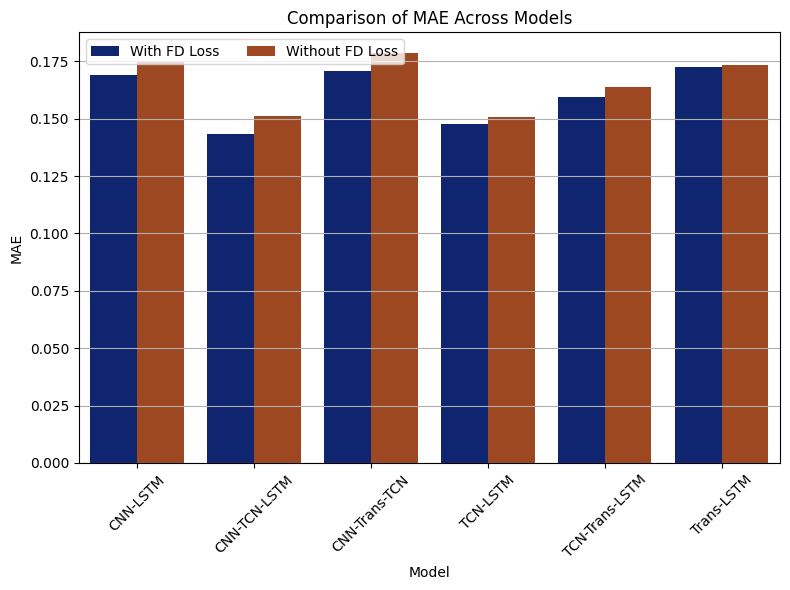

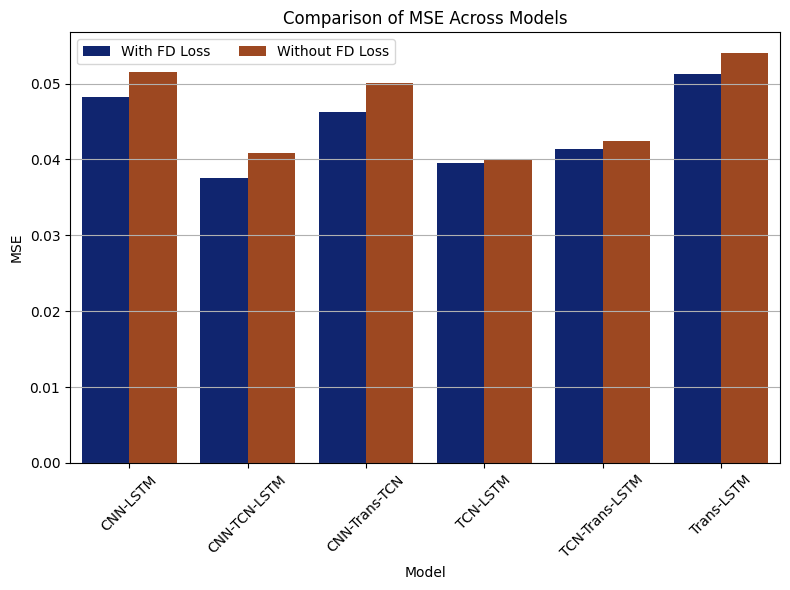

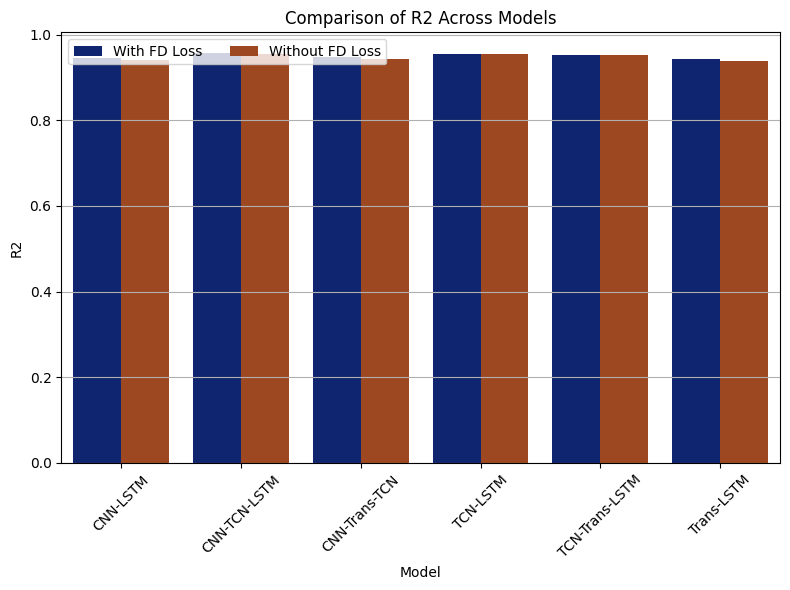

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data setup
models = ["CNN-LSTM", "CNN-TCN-LSTM", "CNN-Trans-TCN", "TCN-LSTM", "TCN-Trans-LSTM", "Trans-LSTM"]

data = {
    "Model": models,
    "MAE_Without_FD": [0.17516, 0.15133, 0.17872, 0.1508, 0.16369, 0.1733],
    "MAE_With_FD": [0.16907, 0.14337, 0.17074, 0.14752, 0.15958, 0.17271],
    "MSE_Without_FD": [0.05149, 0.04087, 0.05005, 0.03994, 0.04237, 0.05405],
    "MSE_With_FD": [0.04826, 0.03752, 0.0463, 0.03955, 0.04143, 0.05121],
    "R2_Without_FD": [0.94151, 0.95352, 0.94313, 0.95465, 0.95189, 0.93881],
    "R2_With_FD": [0.94517, 0.95739, 0.94741, 0.95507, 0.95293, 0.94276]
}

df = pd.DataFrame(data)

# Melt dataframe for Seaborn compatibility
df_melted = pd.DataFrame()
metrics = ['MAE', 'MSE', 'R2']

for metric in metrics:
    temp_df = pd.DataFrame({
        "Model": models * 2,
        "Value": df[f"{metric}_With_FD"].tolist() + df[f"{metric}_Without_FD"].tolist(),
        "FD_Loss": ["With FD Loss"] * len(models) + ["Without FD Loss"] * len(models),
        "Metric": [metric] * len(models) * 2
    })
    df_melted = pd.concat([df_melted, temp_df], ignore_index=True)

# Plotting with Seaborn
for metric in metrics:
    plt.figure(figsize=(8, 6))
    subset = df_melted[df_melted["Metric"] == metric]
    sns.barplot(
        data=subset,
        x="Model",
        y="Value",
        hue="FD_Loss",
        palette="dark"
    )
    plt.title(f'Comparison of {metric} Across Models')
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.legend(title="", loc="upper left", ncol=2)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



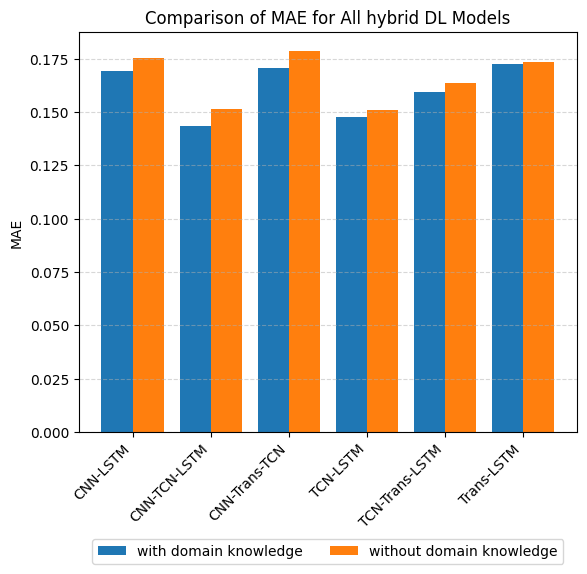

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df1 and df2 are your two DataFrames
# Extract 'Average' rows (last row in each, assuming index 10)
mae_df1 = pivot_df1_with_avg.iloc[10].filter(like='MAE')
mae_df2 = pivot_df_with_avg.iloc[10].filter(like='MAE')

# Prepare plot
labels = mae_df1.index.str.replace("MAE_", "")
x = range(len(labels))

plt.figure(figsize=(6, 6))
plt.bar([i - 0.2 for i in x], mae_df1.values, width=0.4, label='with domain knowledge', align='center')
plt.bar([i + 0.2 for i in x], mae_df2.values, width=0.4, label='without domain knowledge', align='center')

plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("Comparison of MAE for All hybrid DL Models")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


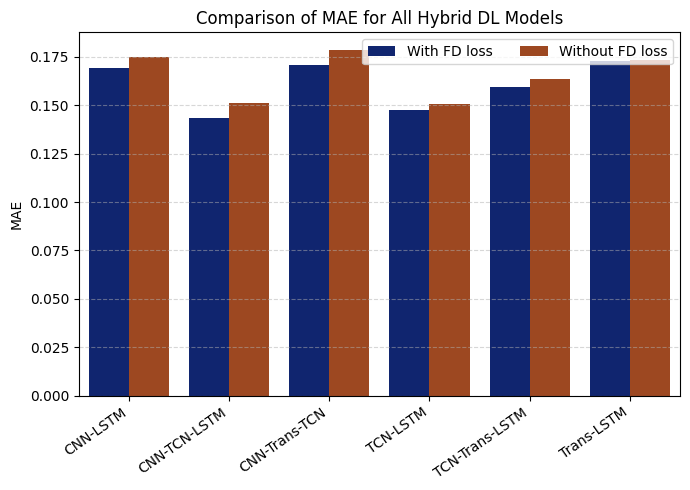

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract MAE values from the average row
mae_df1 = pivot_df1_with_avg.iloc[10].filter(like='MAE')
mae_df2 = pivot_df_with_avg.iloc[10].filter(like='MAE')

# Create tidy DataFrame for Seaborn
df_mae = pd.DataFrame({
    'Model': mae_df1.index.str.replace("MAE_", ""),
    'With FD loss': mae_df1.values,
    'Without FD loss': mae_df2.values
})

# Melt to long format
df_long = df_mae.melt(id_vars='Model', var_name='Domain Knowledge', value_name='MAE')

# Plot with Seaborn
plt.figure(figsize=(7, 5))
sns.barplot(data=df_long, x='Model', y='MAE', hue='Domain Knowledge', palette='dark')

# Customize
plt.title("Comparison of MAE for All Hybrid DL Models")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=35, ha='right')
plt.legend(loc='upper right', ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


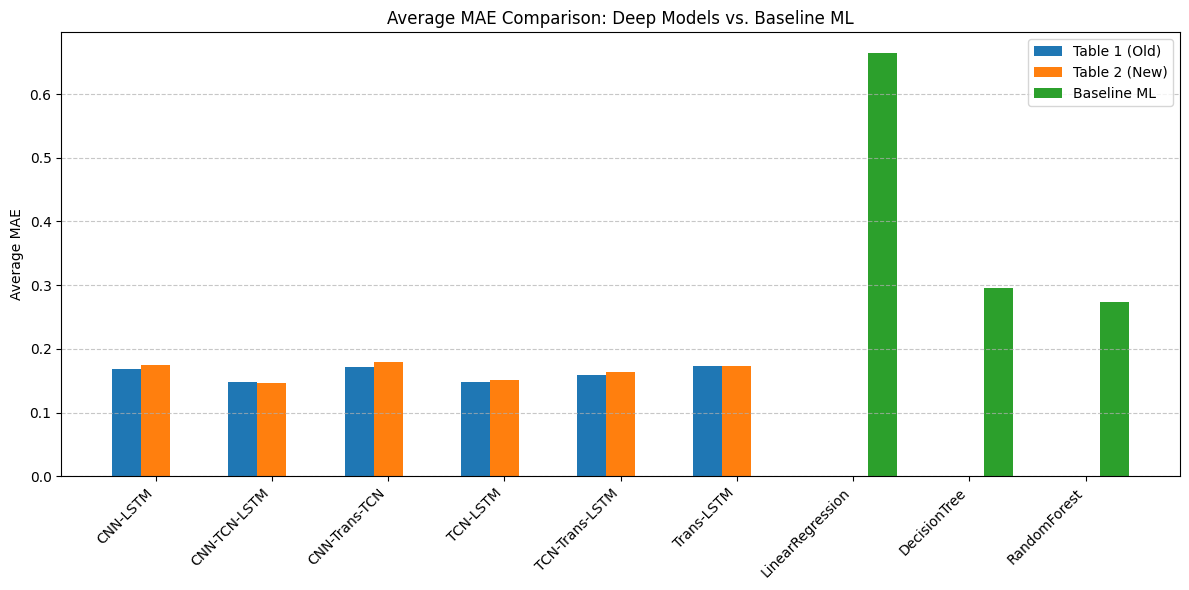

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Extract MAE rows from both DataFrames ---
mae_df1 = pivot_df1_with_avg.iloc[10].filter(like='MAE')
mae_df2 = pivot_df_with_avg.iloc[10].filter(like='MAE') # average row from second table

# --- Step 2: Baseline MAE values ---
baseline_mae = {
    'LinearRegression': 0.6637,
    'DecisionTree': 0.2959,
    'RandomForest': 0.2734
}

# Combine all labels
labels = list(mae_df1.index.str.replace('MAE_', '')) + list(baseline_mae.keys())

# Fill missing values with 0 and keep a mask to optionally style them
mae1_values = list(mae_df1.values) + [0] * 3
mae2_values = list(mae_df2.values) + [0] * 3
baseline_values = [0] * len(mae_df1) + list(baseline_mae.values())

# Plotting
x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width for i in x], mae1_values, width=bar_width, label='Table 1 (Old)')
plt.bar(x, mae2_values, width=bar_width, label='Table 2 (New)')
plt.bar([i + bar_width for i in x], baseline_values, width=bar_width, label='Baseline ML')

plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
plt.ylabel("Average MAE")
plt.title("Average MAE Comparison: Deep Models vs. Baseline ML")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


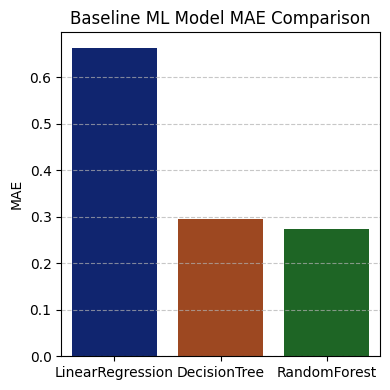

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Baseline MAE values
baseline_mae = {
    'LinearRegression': 0.6637,
    'DecisionTree': 0.2959,
    'RandomForest': 0.2734
}

# Convert to DataFrame
df = pd.DataFrame({
    'Model': list(baseline_mae.keys()),
    'MAE': list(baseline_mae.values())
})

# Plot with Seaborn
plt.figure(figsize=(4, 4))
sns.barplot(data=df, x='Model', y='MAE', palette='dark')

# Formatting
plt.title("Baseline ML Model MAE Comparison")
plt.ylabel("MAE")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



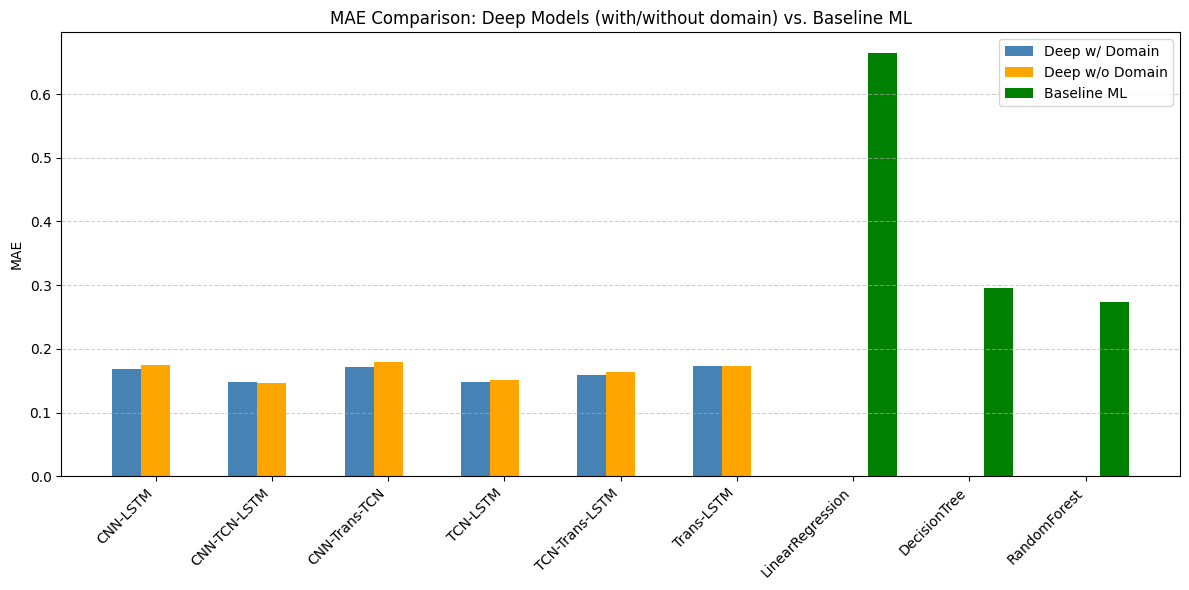

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Deep models
models = ['CNN-LSTM', 'CNN-TCN-LSTM', 'CNN-Trans-TCN',
          'TCN-LSTM', 'TCN-Trans-LSTM', 'Trans-LSTM']

# MAE values
with_domain = [0.16907, 0.14757, 0.17074, 0.14752, 0.15958, 0.17271]
without_domain = [0.17516, 0.1456, 0.17872, 0.1508, 0.16369, 0.1733]

# Baseline ML
baseline_models = ['LinearRegression', 'DecisionTree', 'RandomForest']
baseline_mae = [0.6637, 0.2959, 0.2734]

# Merge all
all_labels = models + baseline_models
x = np.arange(len(all_labels))

# Fill groups
with_domain_full = with_domain + [None]*3
without_domain_full = without_domain + [None]*3
baseline_full = [None]*6 + baseline_mae

# Handle missing values safely (replace None with 0 for plotting)
bar1_vals = [v if v is not None else 0 for v in with_domain_full]
bar2_vals = [v if v is not None else 0 for v in without_domain_full]
bar3_vals = [v if v is not None else 0 for v in baseline_full]

bar_width = 0.25

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, bar1_vals, width=bar_width, label='Deep w/ Domain', color='steelblue')
plt.bar(x, bar2_vals, width=bar_width, label='Deep w/o Domain', color='orange')
plt.bar(x + bar_width, bar3_vals, width=bar_width, label='Baseline ML', color='green')

# Labels
plt.xticks(ticks=x, labels=all_labels, rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('MAE Comparison: Deep Models (with/without domain) vs. Baseline ML')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
